In [1]:
%run ./work/lib/Config.ipynb

In [2]:
import chart_studio.tools as tls
from chart_studio import plotly as py
import plotly.graph_objects as go

db = connect()

# Query the database for a collection of meat, fruit, and vegetables.
# We hope that PCA will distinguish between meat and plant-based foods.

def query():
    return("""SELECT food.ndb_no
        , fdgrp_cd
        , shrt_desc
        , fdgrp_desc
        , fdgrp_cd IN ('0100', '0500', '1000', '1300', '1700') AS is_animal
        , IF(fdgrp_cd='1100', 0, IF(fdgrp_cd='0900', 1, IF(fdgrp_cd IN ('1200', '1600'), 2, IF(fdgrp_cd='0100', 3, IF(fdgrp_cd IN ('0500','1000'), 4, 5))))) AS food_class
        , fdgrp_cd IN ('0100') AS is_dairy
        , fdgrp_cd IN ('0500', '1000') AS is_white_meat
        , fdgrp_cd IN ('1300', '1700') AS is_red_meat
        , fdgrp_cd IN ('0900') AS is_fruit
        , fdgrp_cd IN ('1100') AS is_vegetable
        , fdgrp_cd IN ('1200') AS is_nut_or_seed
        , fdgrp_cd IN ('1600') AS is_legume
        , COALESCE(nut2.nutr_val,0) AS procnt
        , COALESCE(nut3.nutr_val,0) AS chocdf
        , COALESCE(nut4.nutr_val,0) AS fibtg
        , COALESCE(nut7.nutr_val,0) AS mg
        , COALESCE(nut8.nutr_val,0) AS p
        , COALESCE(nut11.nutr_val,0) AS zn
        , COALESCE(nut12.nutr_val,0) AS cu
        , COALESCE(nut18.nutr_val,0) AS ribf
    FROM
        food_des AS food
        JOIN fd_group USING(fdgrp_cd)
        JOIN usda.nut_data AS nut2 ON nut2.nutr_no = 203 AND nut2.ndb_no = food.ndb_no
        JOIN usda.nut_data AS nut3 ON nut3.nutr_no = 205 AND nut3.ndb_no = food.ndb_no
        JOIN usda.nut_data AS nut4 ON nut4.nutr_no = 291 AND nut4.ndb_no = food.ndb_no
        JOIN usda.nut_data AS nut7 ON nut7.nutr_no = 304 AND nut7.ndb_no = food.ndb_no
        JOIN usda.nut_data AS nut8 ON nut8.nutr_no = 305 AND nut8.ndb_no = food.ndb_no
        JOIN usda.nut_data AS nut11 ON nut11.nutr_no = 309 AND nut11.ndb_no = food.ndb_no
        JOIN usda.nut_data AS nut12 ON nut12.nutr_no = 312 AND nut12.ndb_no = food.ndb_no
        JOIN usda.nut_data AS nut18 ON nut18.nutr_no = 405 AND nut18.ndb_no = food.ndb_no
    WHERE
        fdgrp_cd IN ('0100', '0500', '0900', '1000', '1100', '1200', '1300', '1600', '1700')
    ;""")

# Graph the results for selected food groups
def scatterplot_1d(data, mask):
    tls.set_credentials_file(username=PLOTLY_USER, api_key=PLOTLY_AUTH)
    
    traces = []
    #names = ['Vegetables', 'Fruits', 'Nuts, Seeds, and Legumes', 'Dairy', 'White Meat', 'Red Meat']
    names = ['Plant', 'Animal']
    #names = ['Low', 'Medium', 'High']

    for n in range(max(mask)+1):
        x = data[mask==n,0]
        y = np.full((1,len(x)), n).flatten()
        trace = go.Scatter(
            x=x,
            y=y,
            mode='markers',
            name=names[n],
            marker=go.Marker(
                size=12,
                line=go.Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5),
            opacity=0.5))
        traces.append(trace)

    MyLayout = go.Layout(xaxis=go.layout.XAxis(showline=False),
                    yaxis=go.layout.YAxis(showline=False))
    return go.Figure(data=traces, layout=MyLayout)

# Graph the given points, colored by label
def scatterplot_2d(data, labels):
    tls.set_credentials_file(username=PLOTLY_USER, api_key=PLOTLY_AUTH)
    
    traces = []
    names = list(set(labels))
    
    for name in names:
        x = data[labels==name,0]
        y = data[labels==name,1]
        trace = go.Scatter(
            x=x,
            y=y,
            mode='markers',
            name=name,
            marker=go.Marker(
                size=12,
                line=go.Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5),
            opacity=0.5))
        traces.append(trace)

    MyLayout = go.Layout(xaxis=go.layout.XAxis(showline=False),
                    yaxis=go.layout.YAxis(showline=False))
    return go.Figure(data=traces, layout=MyLayout)


In [3]:
# Fetch the data
cur = db.cursor()
cur.execute(query())
data = pd.DataFrame(cur.fetchall())
data.columns = ['ndb_no', 'fdgrp_cd', 'shrt_desc', 'fdgrp_desc', 'is_animal', 'food_class', 'is_dairy', 
                'is_white_meat', 'is_red_meat', 'is_fruit', 'is_vegetable', 'is_nut', 'is_legume', 'procnt', 
                'chocdf', 'fibtg', 'mg', 'p', 'zn', 'cu', 'ribf']

metadata = data.iloc[:, :13]
foods = data.iloc[:, 2]
X = data.iloc[:, 13:]
y = data.iloc[:, 4]

print(X.shape)

(3652, 8)


In [4]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Convert the "animal" flag to text labels
names = ['Plant', 'Animal']
labels = pd.Index([names[i] for i in y])

In [5]:
# Try using QDA to distinguish meat from plants
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Run QDA
sklearn_qda = QDA()
X_qda_sklearn = sklearn_qda.fit(X, y)


# Print some diagnostics
print("QDA accuracy: %4.2f" % (100*sklearn_qda.score(X,y)))

QDA accuracy: 97.12


In [6]:
# Try using LDA to distinguish meat from plants
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Run QDA
sklearn_lda = LDA()
X_lda_sklearn = sklearn_lda.fit(X, y)


# Print some diagnostics
print("LDA accuracy: %4.2f" % (100*sklearn_lda.score(X,y)))

LDA accuracy: 94.72


In [7]:
# Manually compute the class probabilities, as in predict_proba()
transform = np.dot(X.astype(float),sklearn_lda.coef_.T) + sklearn_lda.intercept_
prob0 = np.reciprocal( np.exp(-transform,out=None) + 1, out=None )
prob1 = 1-prob0
probs = pd.concat((pd.DataFrame(prob0),pd.DataFrame(prob1)),axis=1)

# Convert the "animal" flag to text labels
names = ['Plant', 'Animal']
labels = [names[i] for i in y]
labels = pd.Index(labels)

# Take a random sample
from random import random
rindex =  [(random()<0.1) for i in range(len(probs))]

py.iplot(scatterplot_2d(np.array(probs[rindex]), labels[rindex]))

/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning: plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.

  warnings.warn(


In [8]:
# Get the coefficients of the linear classifier's matrix (transposed)
coefs = pd.DataFrame(sklearn_lda.coef_.T)
coefs.columns = pd.Index(['Coefficient'])

# Label the rows by the nutrient codes
coefs.index = pd.Index(X_train.columns)

# Print 'em
print(coefs)

        Coefficient
procnt     0.317428
chocdf    -0.040691
fibtg     -0.493943
mg        -0.035121
p          0.007472
zn         0.368315
cu        -0.645951
ribf       0.805818


In [9]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=25)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# Model Accuracy, how often is the classifier correct?
y_pred=clf.predict(X_test)
print("Accuracy:", str(100*metrics.accuracy_score(y_test, y_pred)))

Accuracy: 99.45255474452554


In [10]:
# How good are just the first two features?

# Make a reduced data set
X2 = X   [['p', 'ribf', 'mg', 'cu', 'zn']]
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.70, random_state=5) # 70% training and 30% test

#Create a Gaussian Classifier
forest=RandomForestClassifier(n_estimators=20, max_depth=1)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest.fit(X2_train,y_train)

# prediction on test set
y_pred=forest.predict(X2_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# What are the relative importances of features?
feature_imp = pd.Series(forest.feature_importances_,index=X2.columns).sort_values(ascending=False)
feature_imp

# Look for the most accurate single tree
trees = forest.estimators_
scores = ["%3.1f"% (100*metrics.accuracy_score(y_test, estimator.predict(X2_test))) for estimator in trees]

ranked = pd.concat((pd.DataFrame(trees),pd.DataFrame(scores)), axis=1)
ranked.columns = ['Tree', 'Score']
ranked.sort_values('Score', ascending=False, inplace=True)

print(ranked)

Accuracy: 0.892843175596402
                                                 Tree Score
10  DecisionTreeClassifier(max_depth=1, max_featur...  86.8
1   DecisionTreeClassifier(max_depth=1, max_featur...  86.8
4   DecisionTreeClassifier(max_depth=1, max_featur...  86.8
5   DecisionTreeClassifier(max_depth=1, max_featur...  86.8
13  DecisionTreeClassifier(max_depth=1, max_featur...  86.8
16  DecisionTreeClassifier(max_depth=1, max_featur...  86.7
18  DecisionTreeClassifier(max_depth=1, max_featur...  86.0
19  DecisionTreeClassifier(max_depth=1, max_featur...  86.0
9   DecisionTreeClassifier(max_depth=1, max_featur...  85.1
14  DecisionTreeClassifier(max_depth=1, max_featur...  85.1
3   DecisionTreeClassifier(max_depth=1, max_featur...  85.1
0   DecisionTreeClassifier(max_depth=1, max_featur...  85.1
7   DecisionTreeClassifier(max_depth=1, max_featur...  85.0
6   DecisionTreeClassifier(max_depth=1, max_featur...  85.0
17  DecisionTreeClassifier(max_depth=1, max_featur...  85.0
15  Decision

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:44

In [11]:
feature_imp = pd.Series(forest.feature_importances_,index=X2.columns).sort_values(ascending=False)
feature_imp

ribf    0.35
p       0.30
mg      0.25
zn      0.10
cu      0.00
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


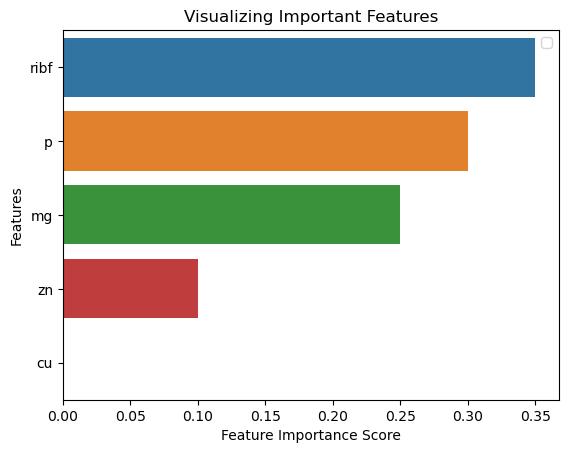

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

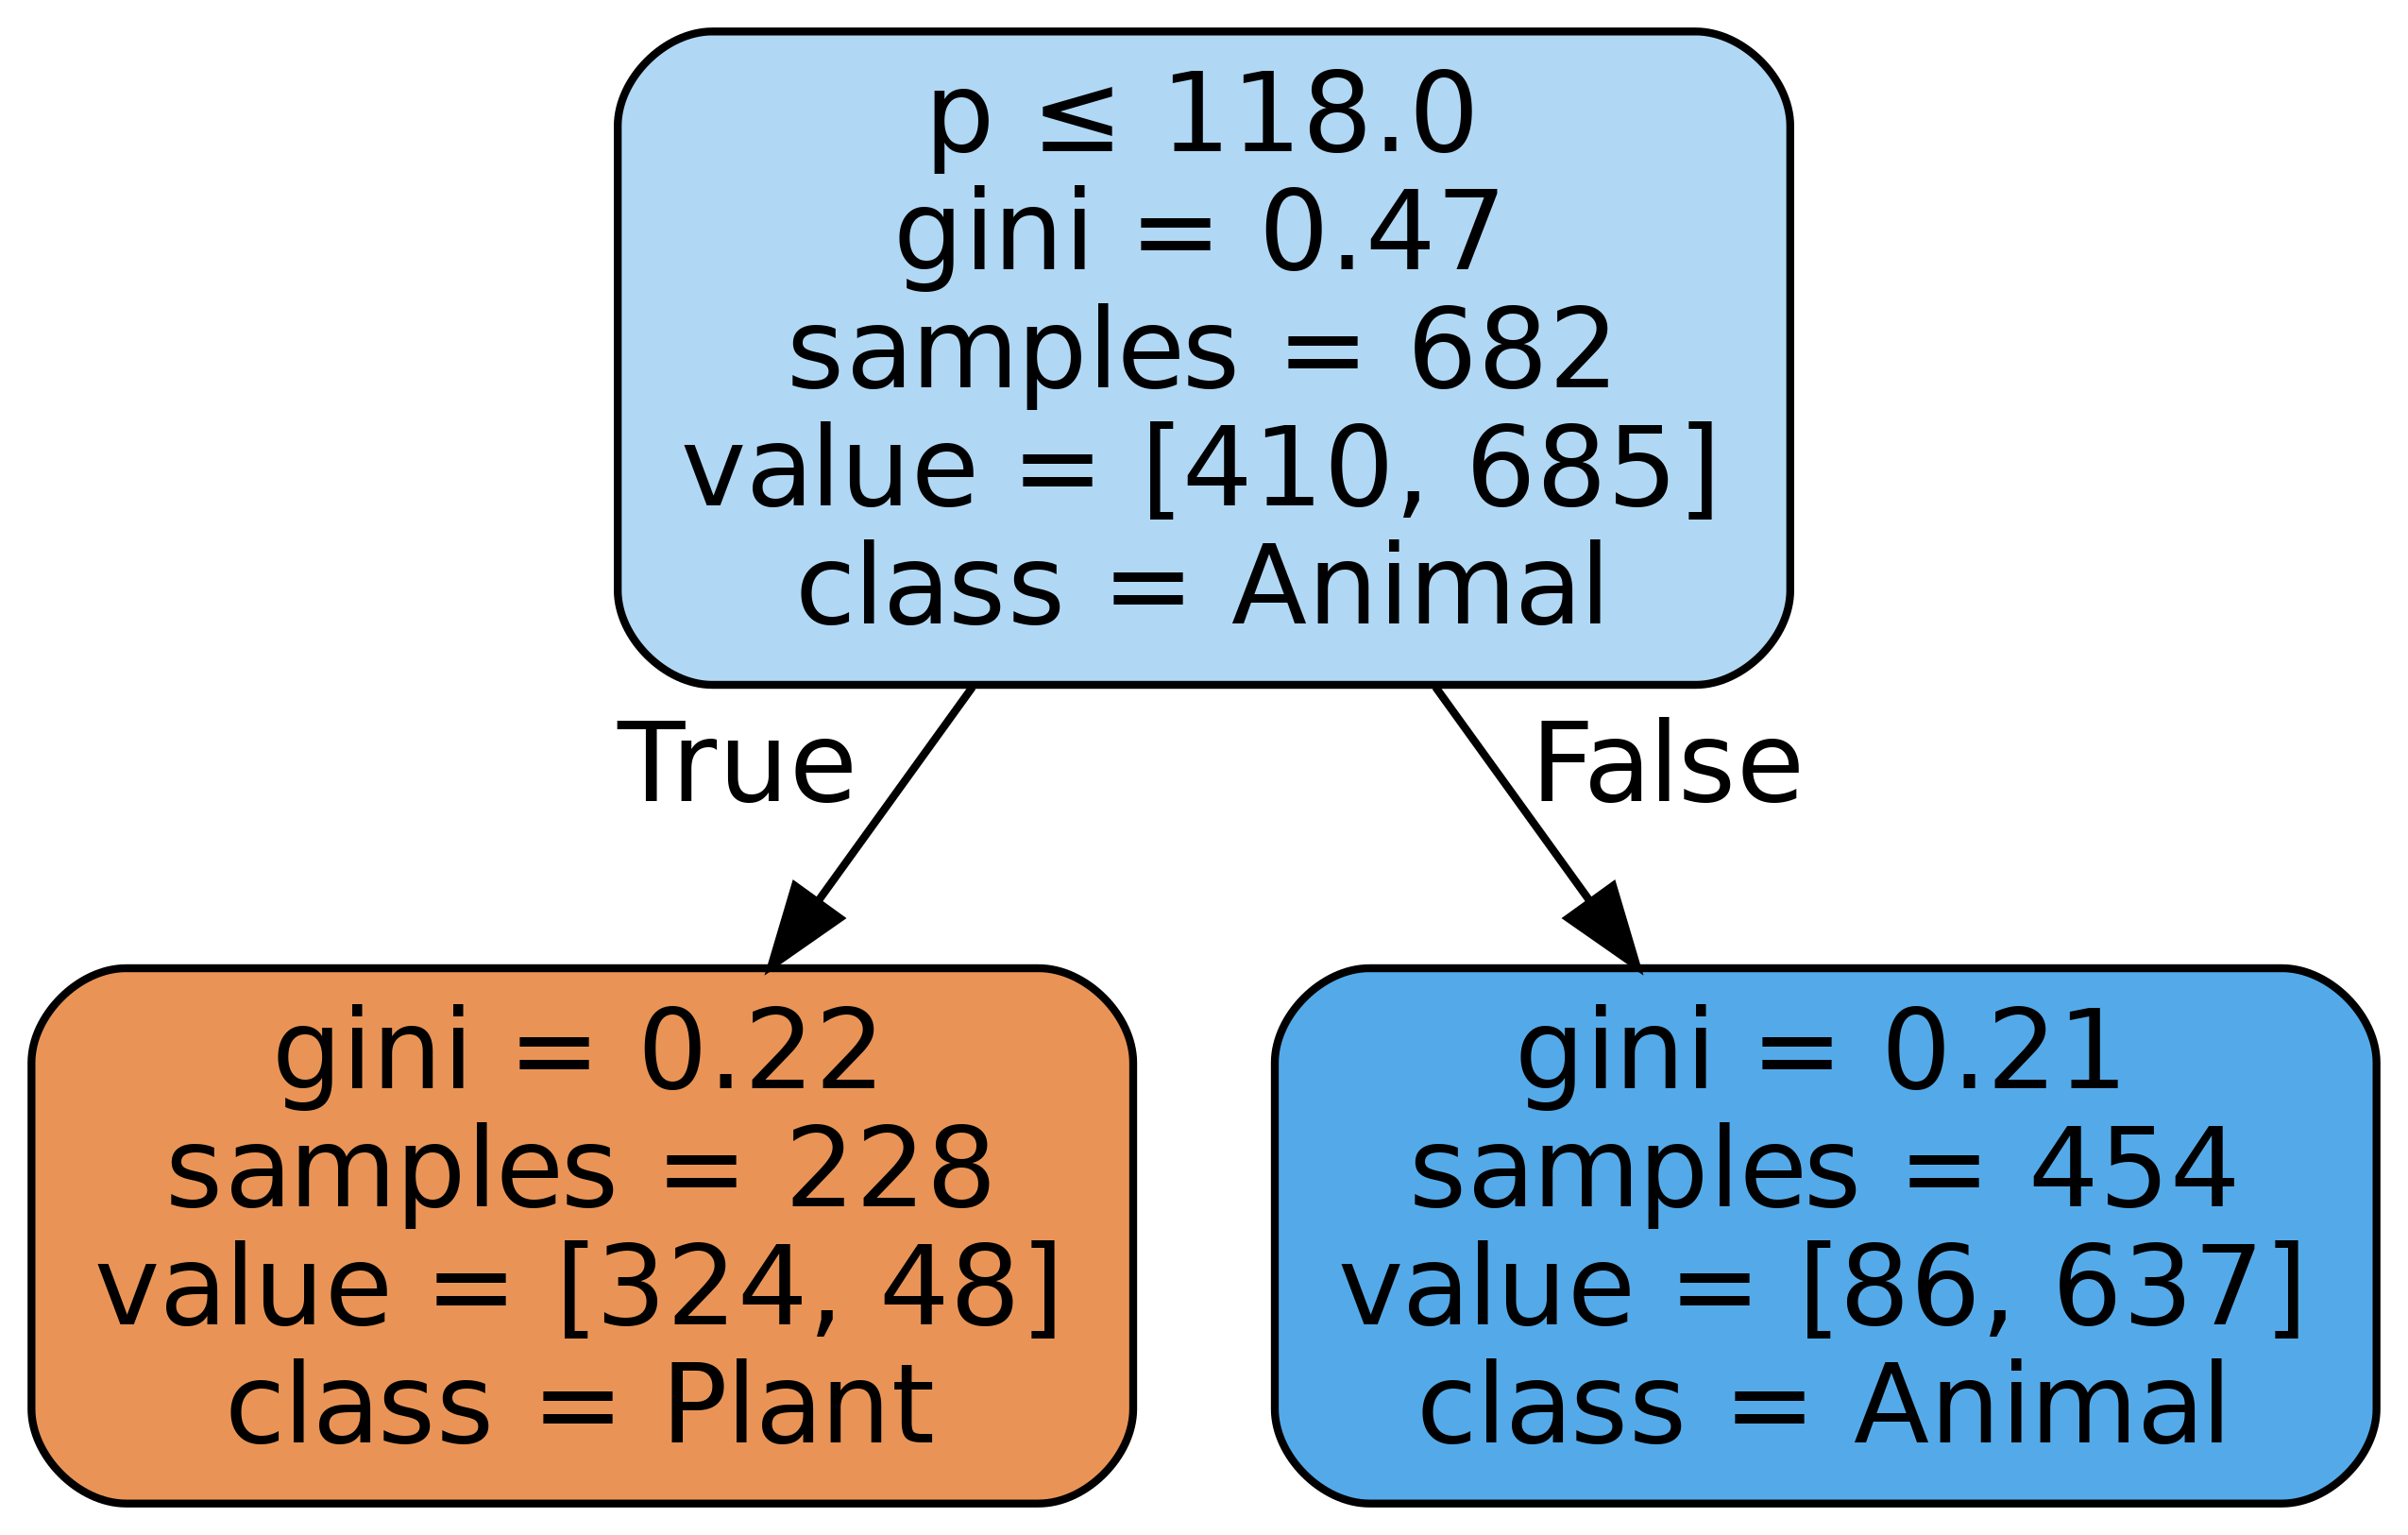

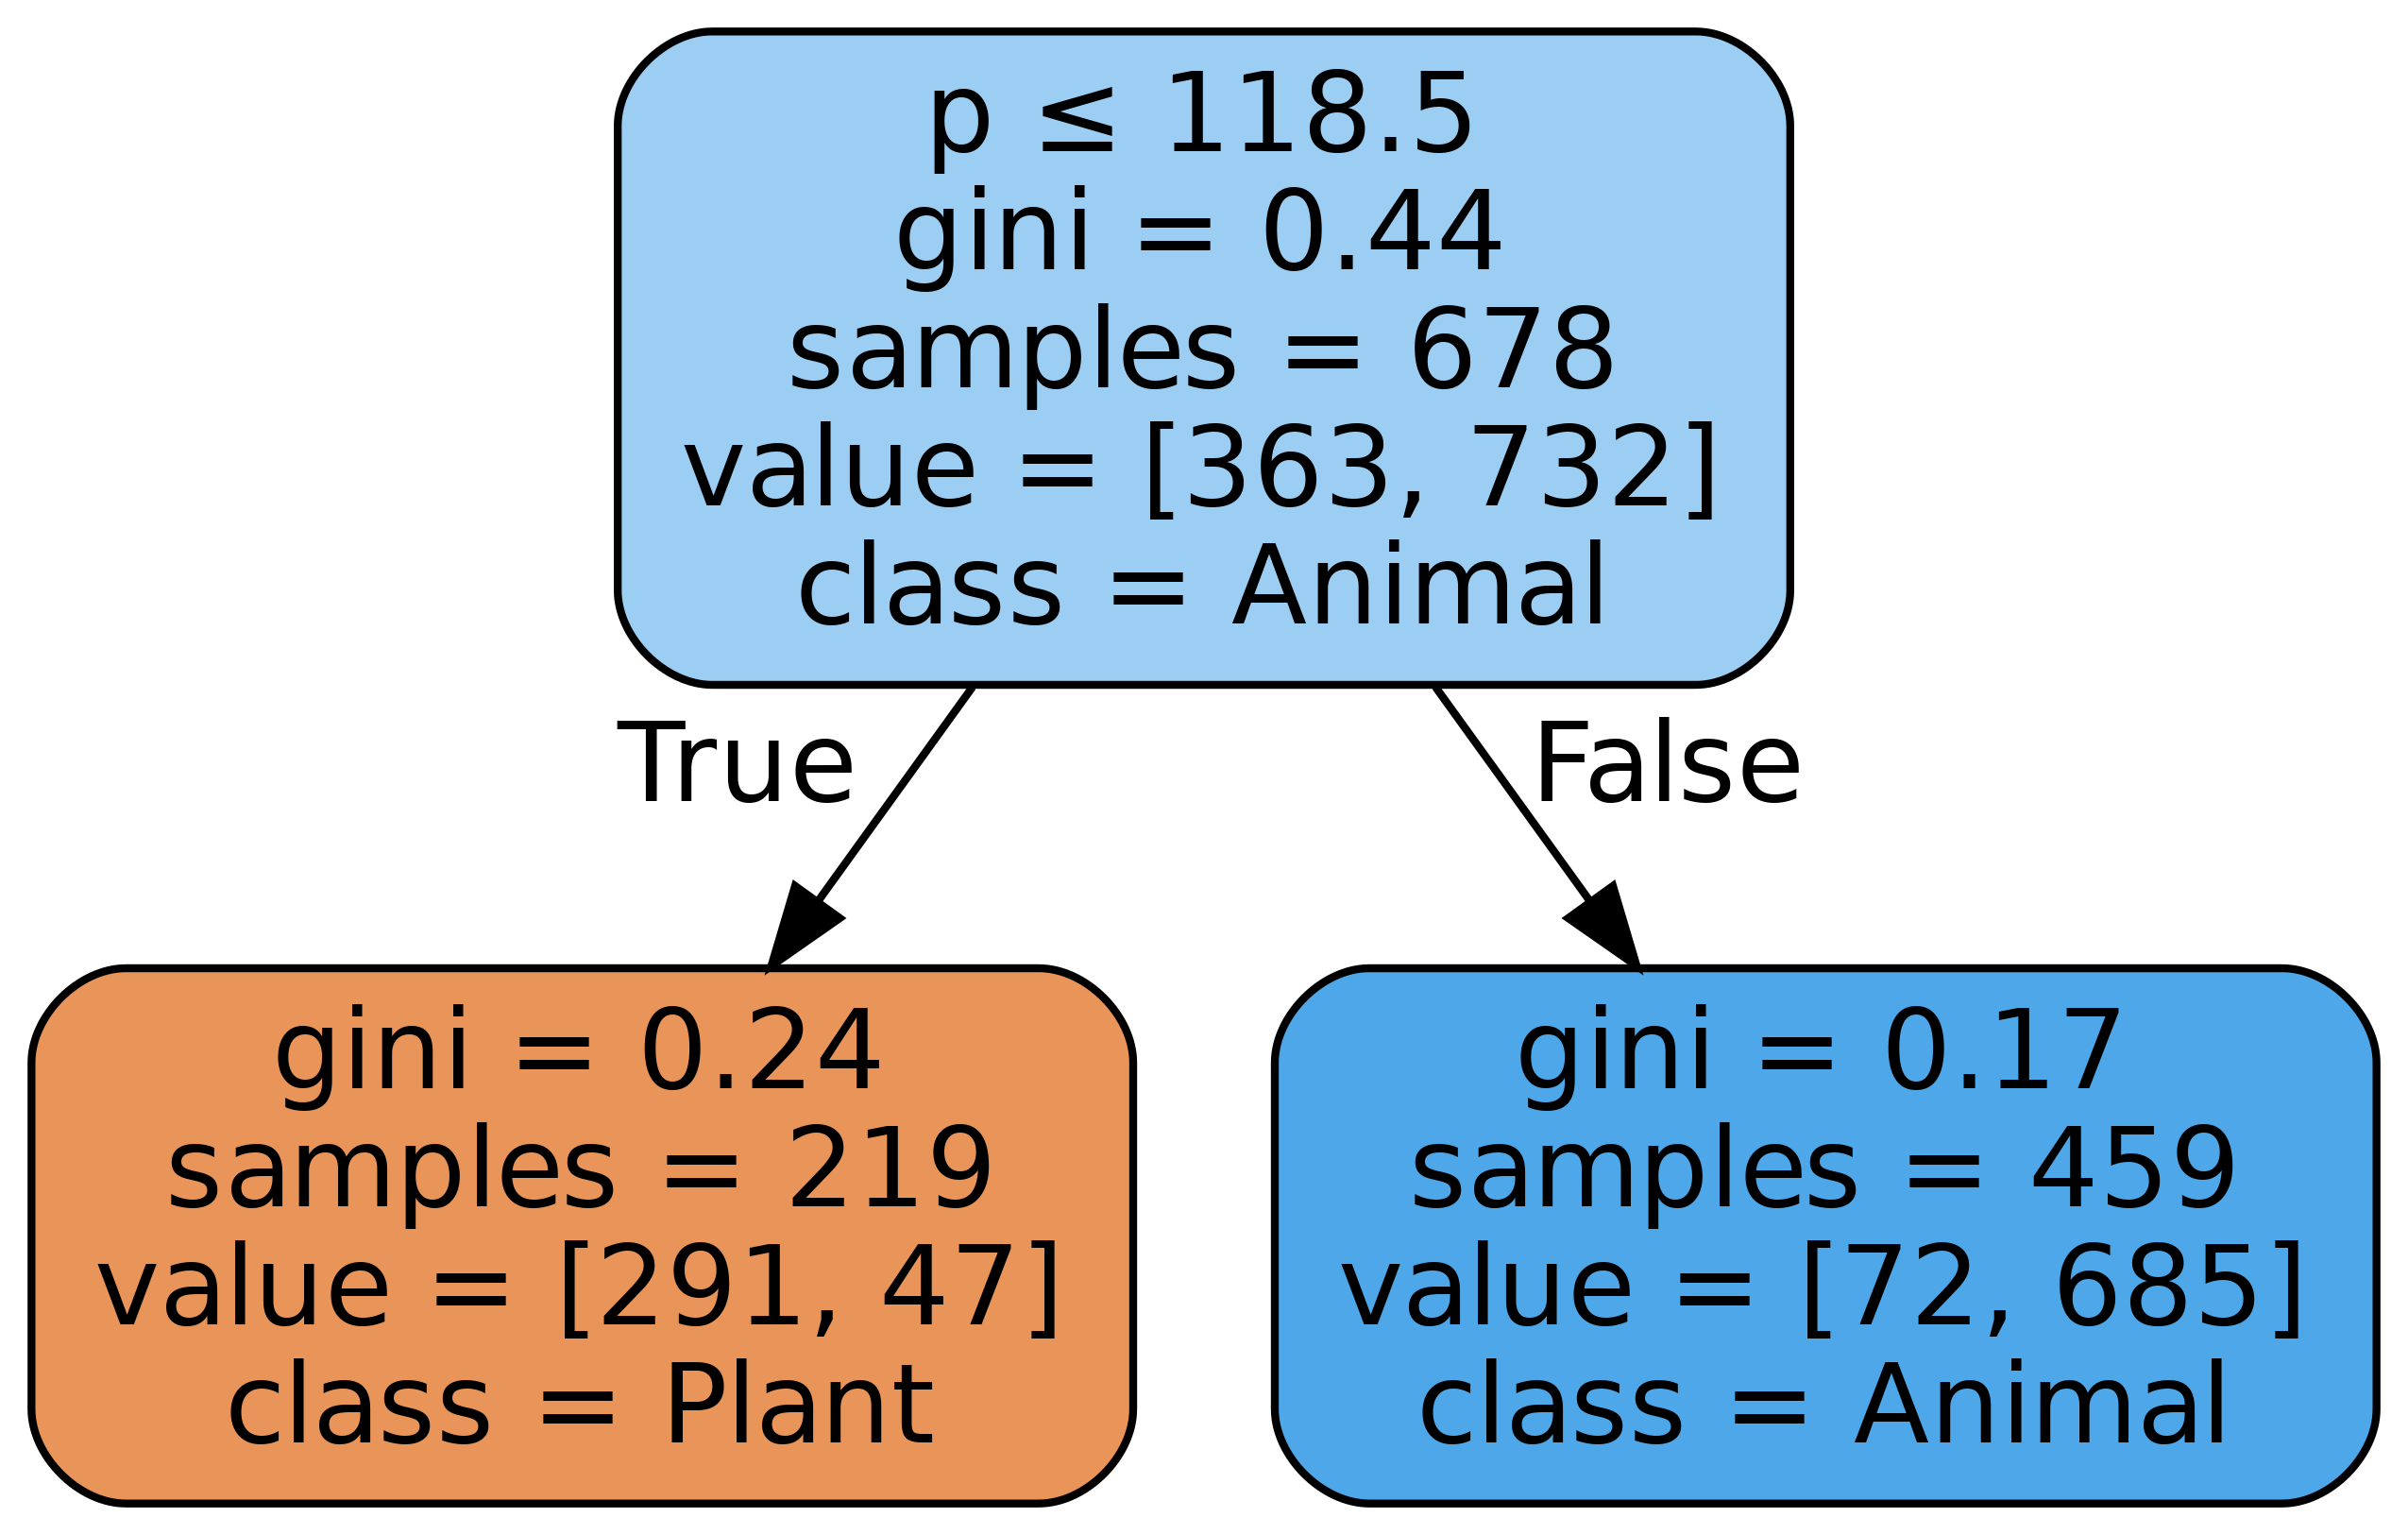

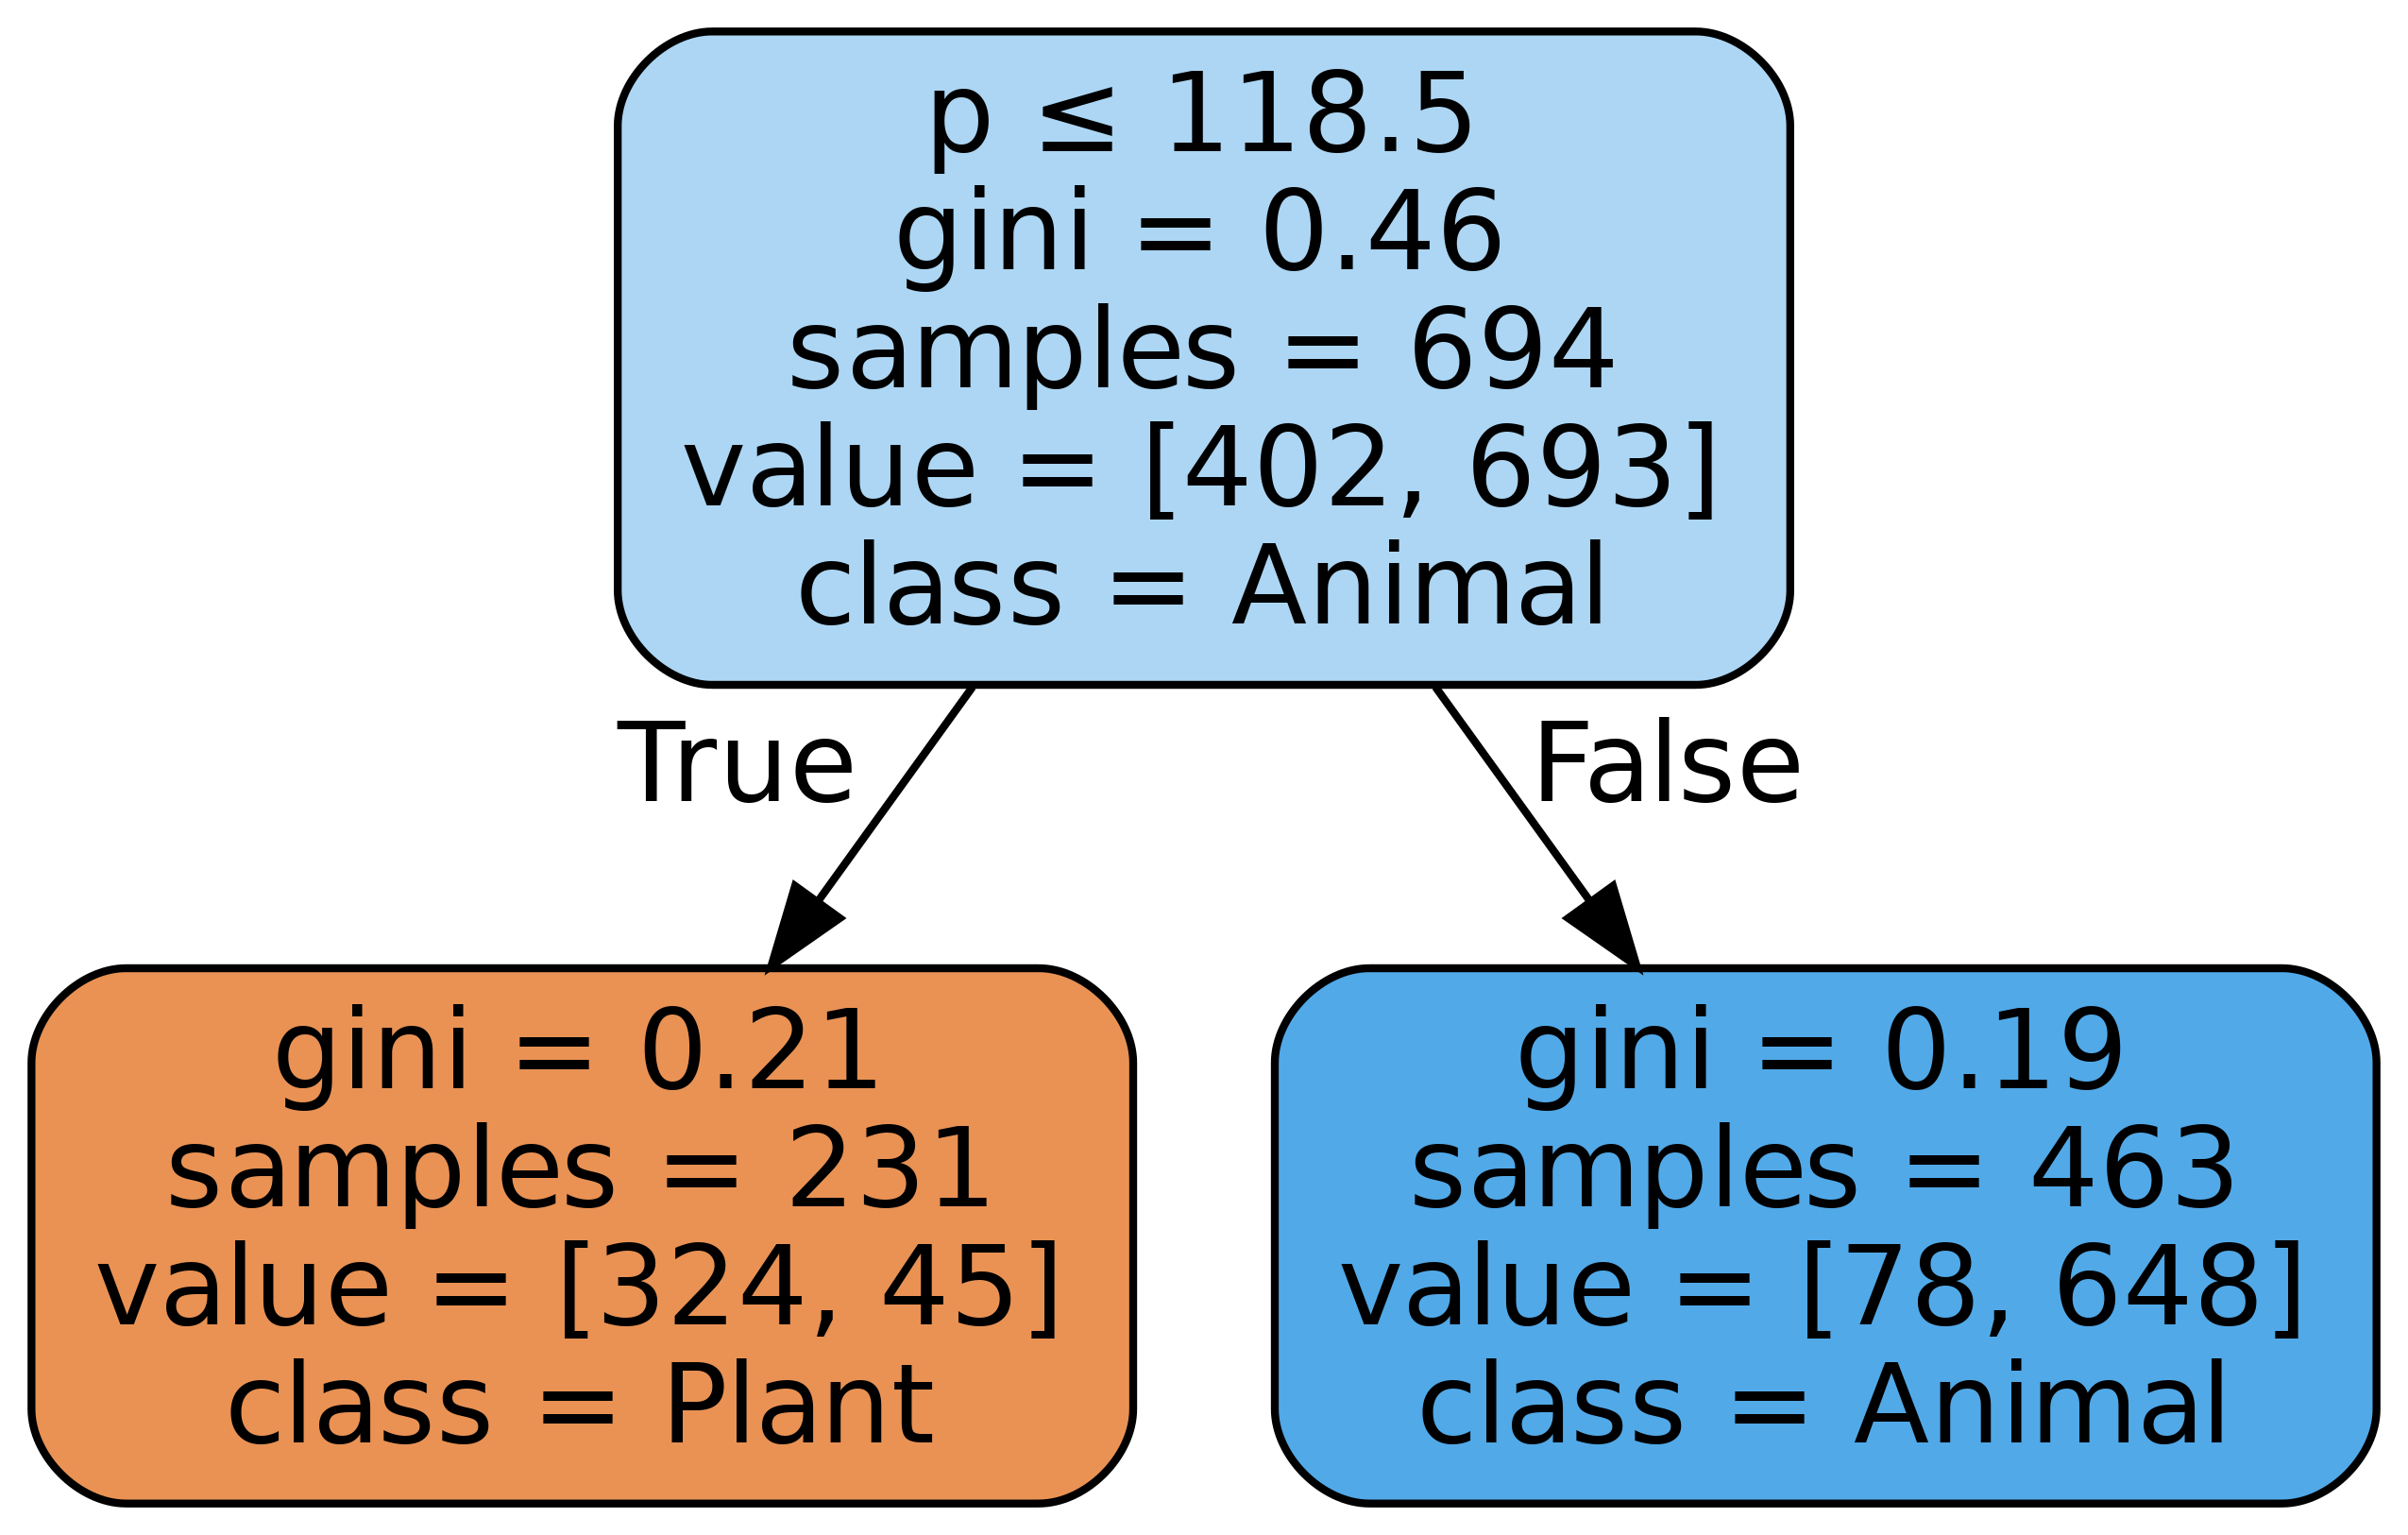

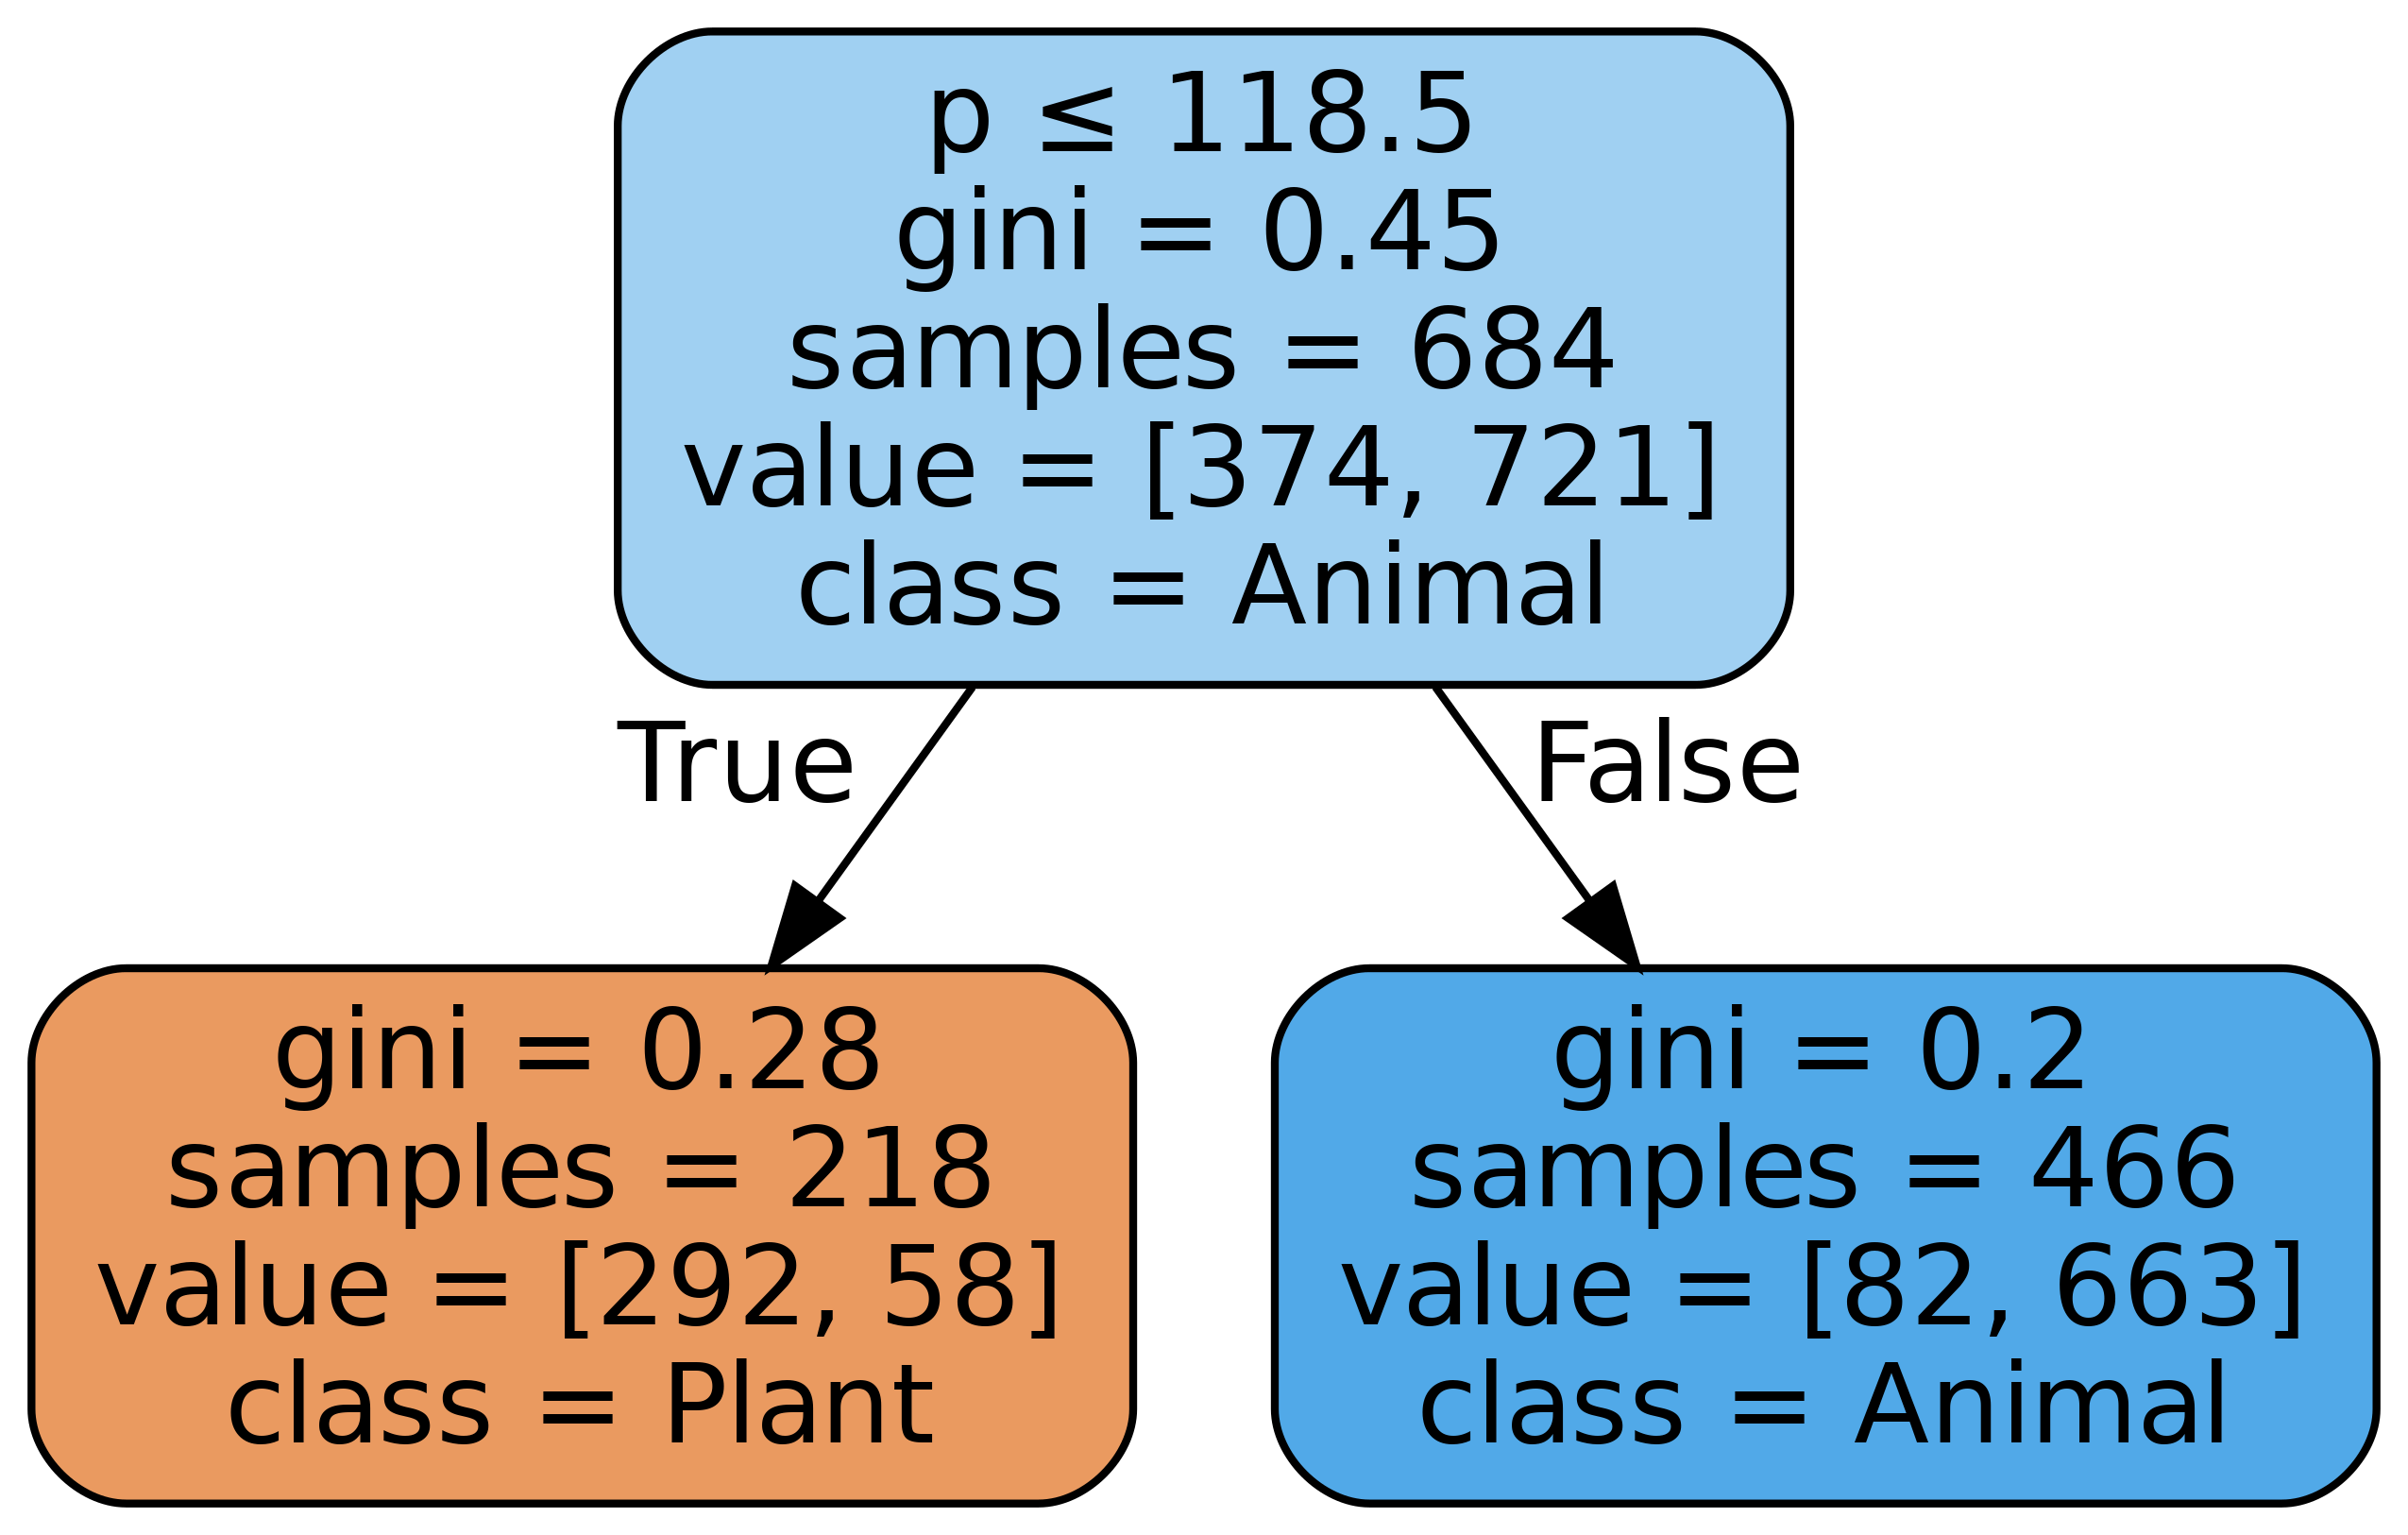

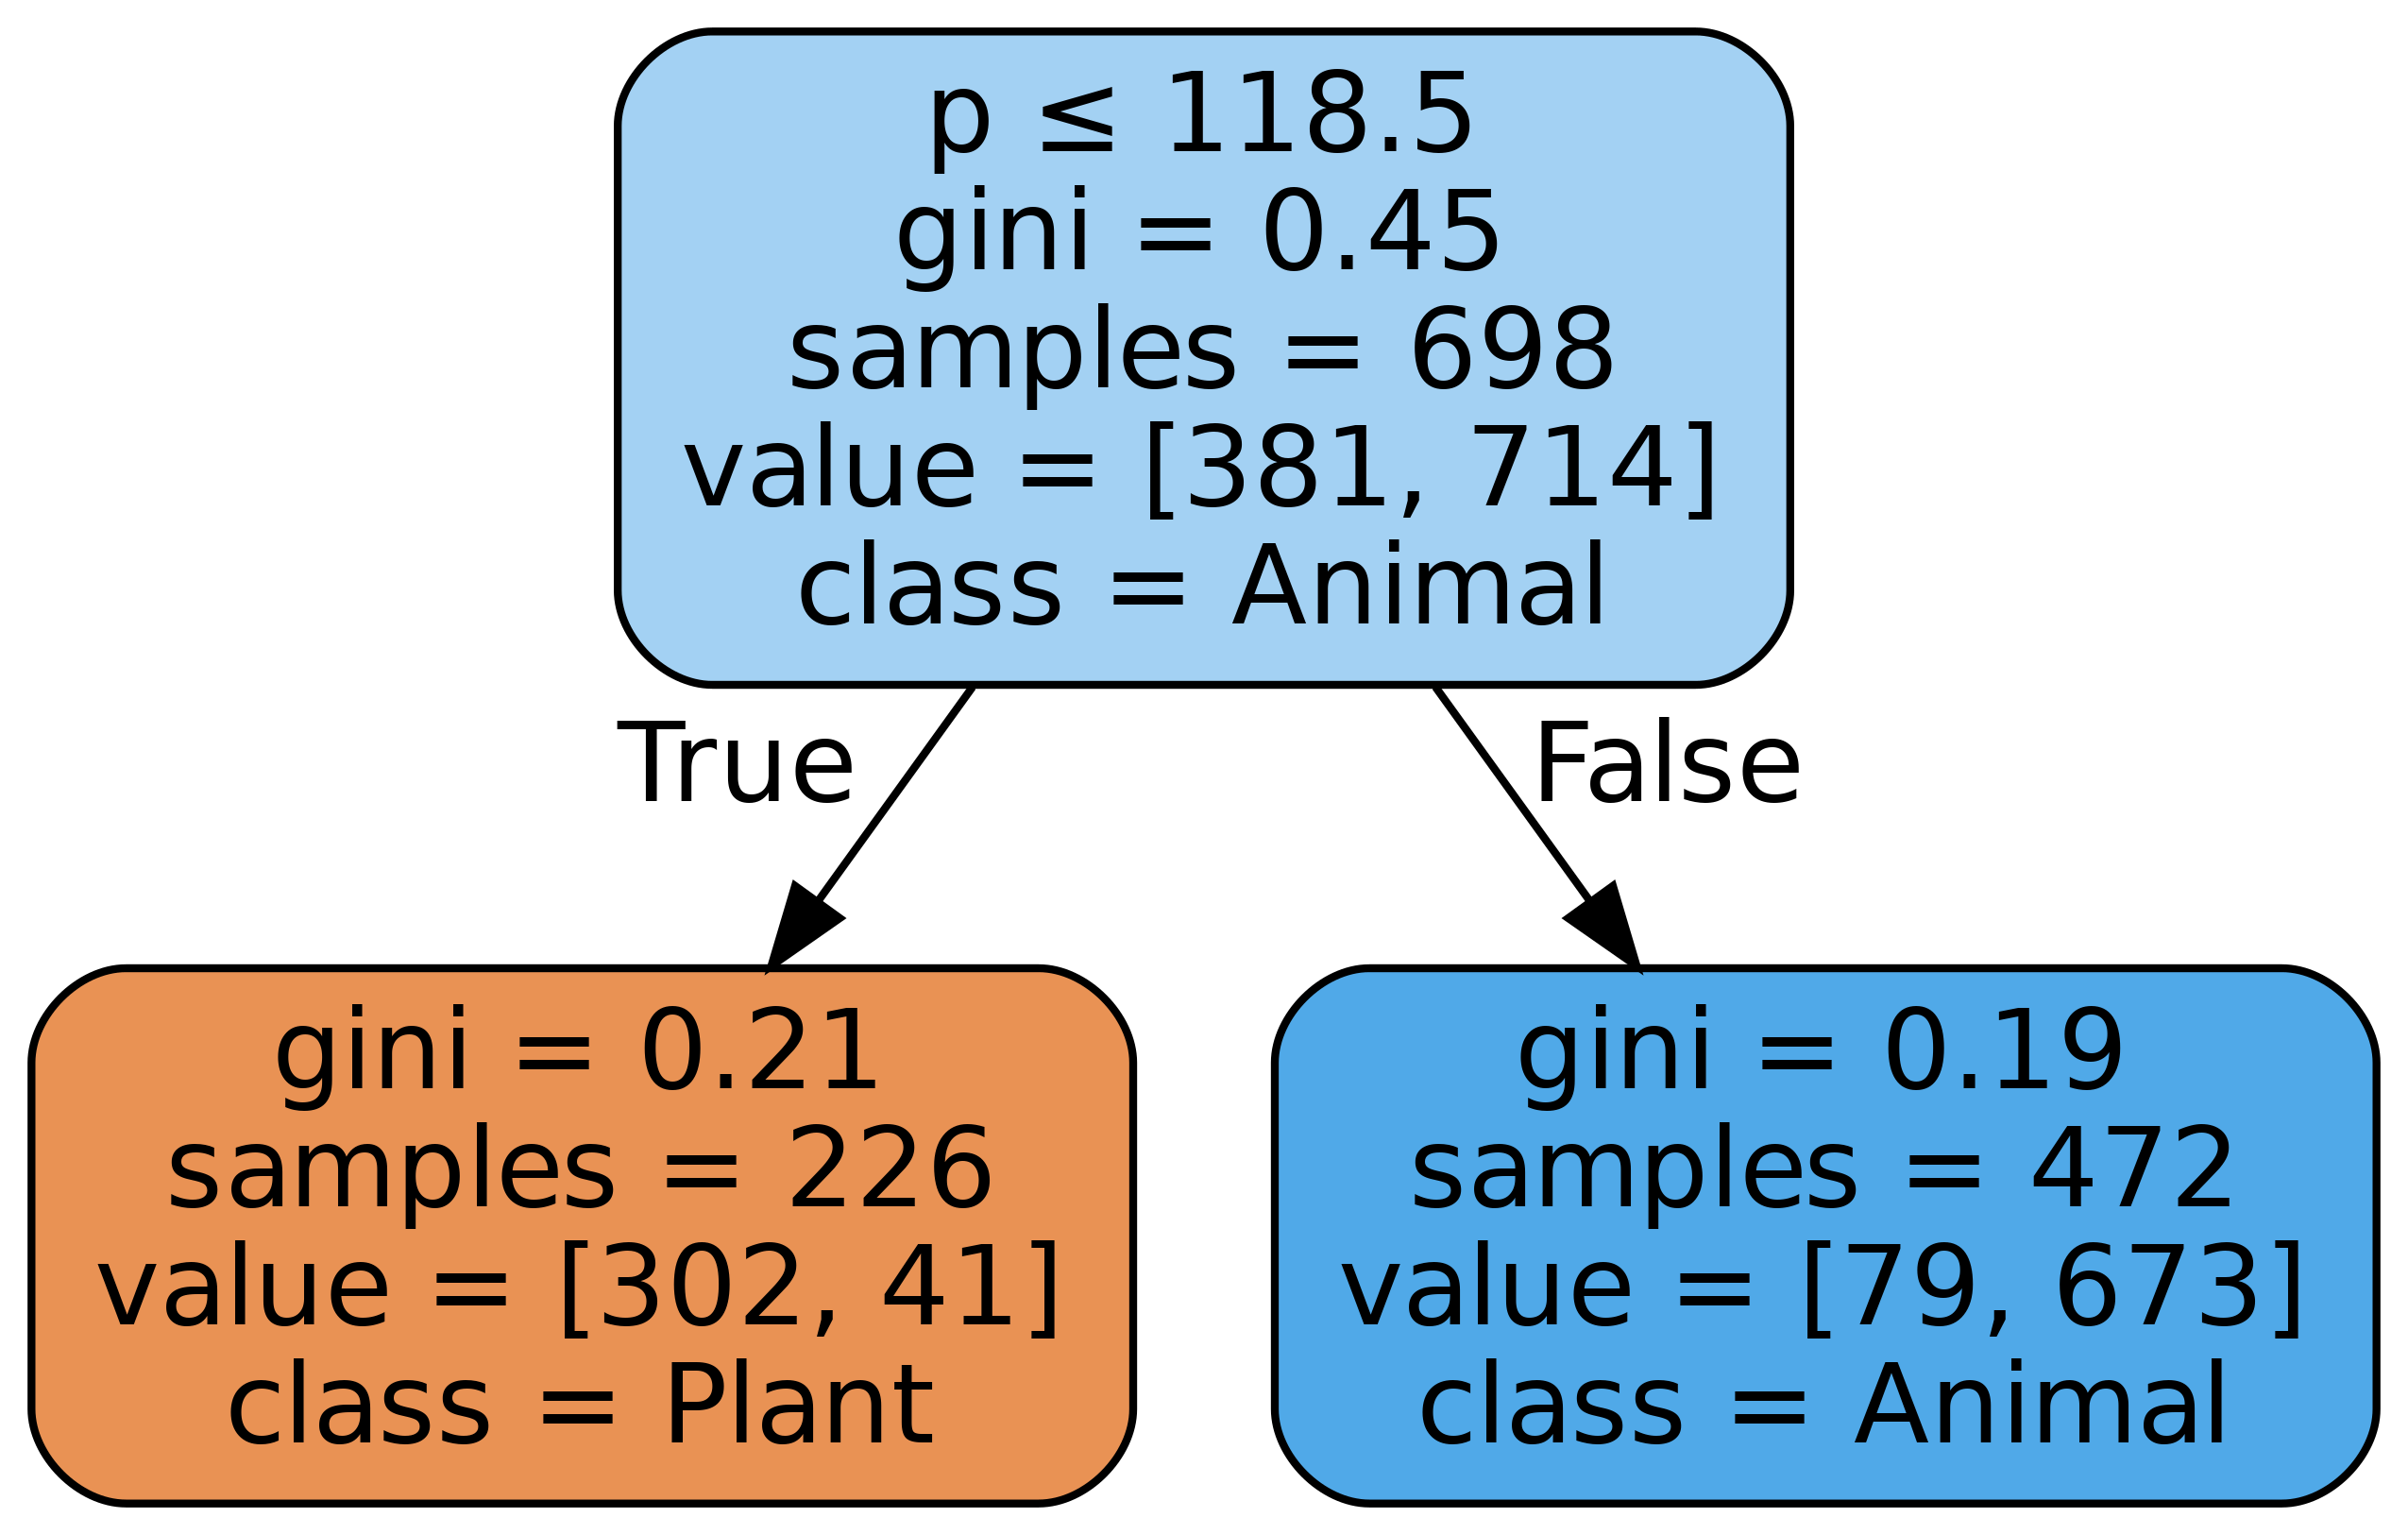

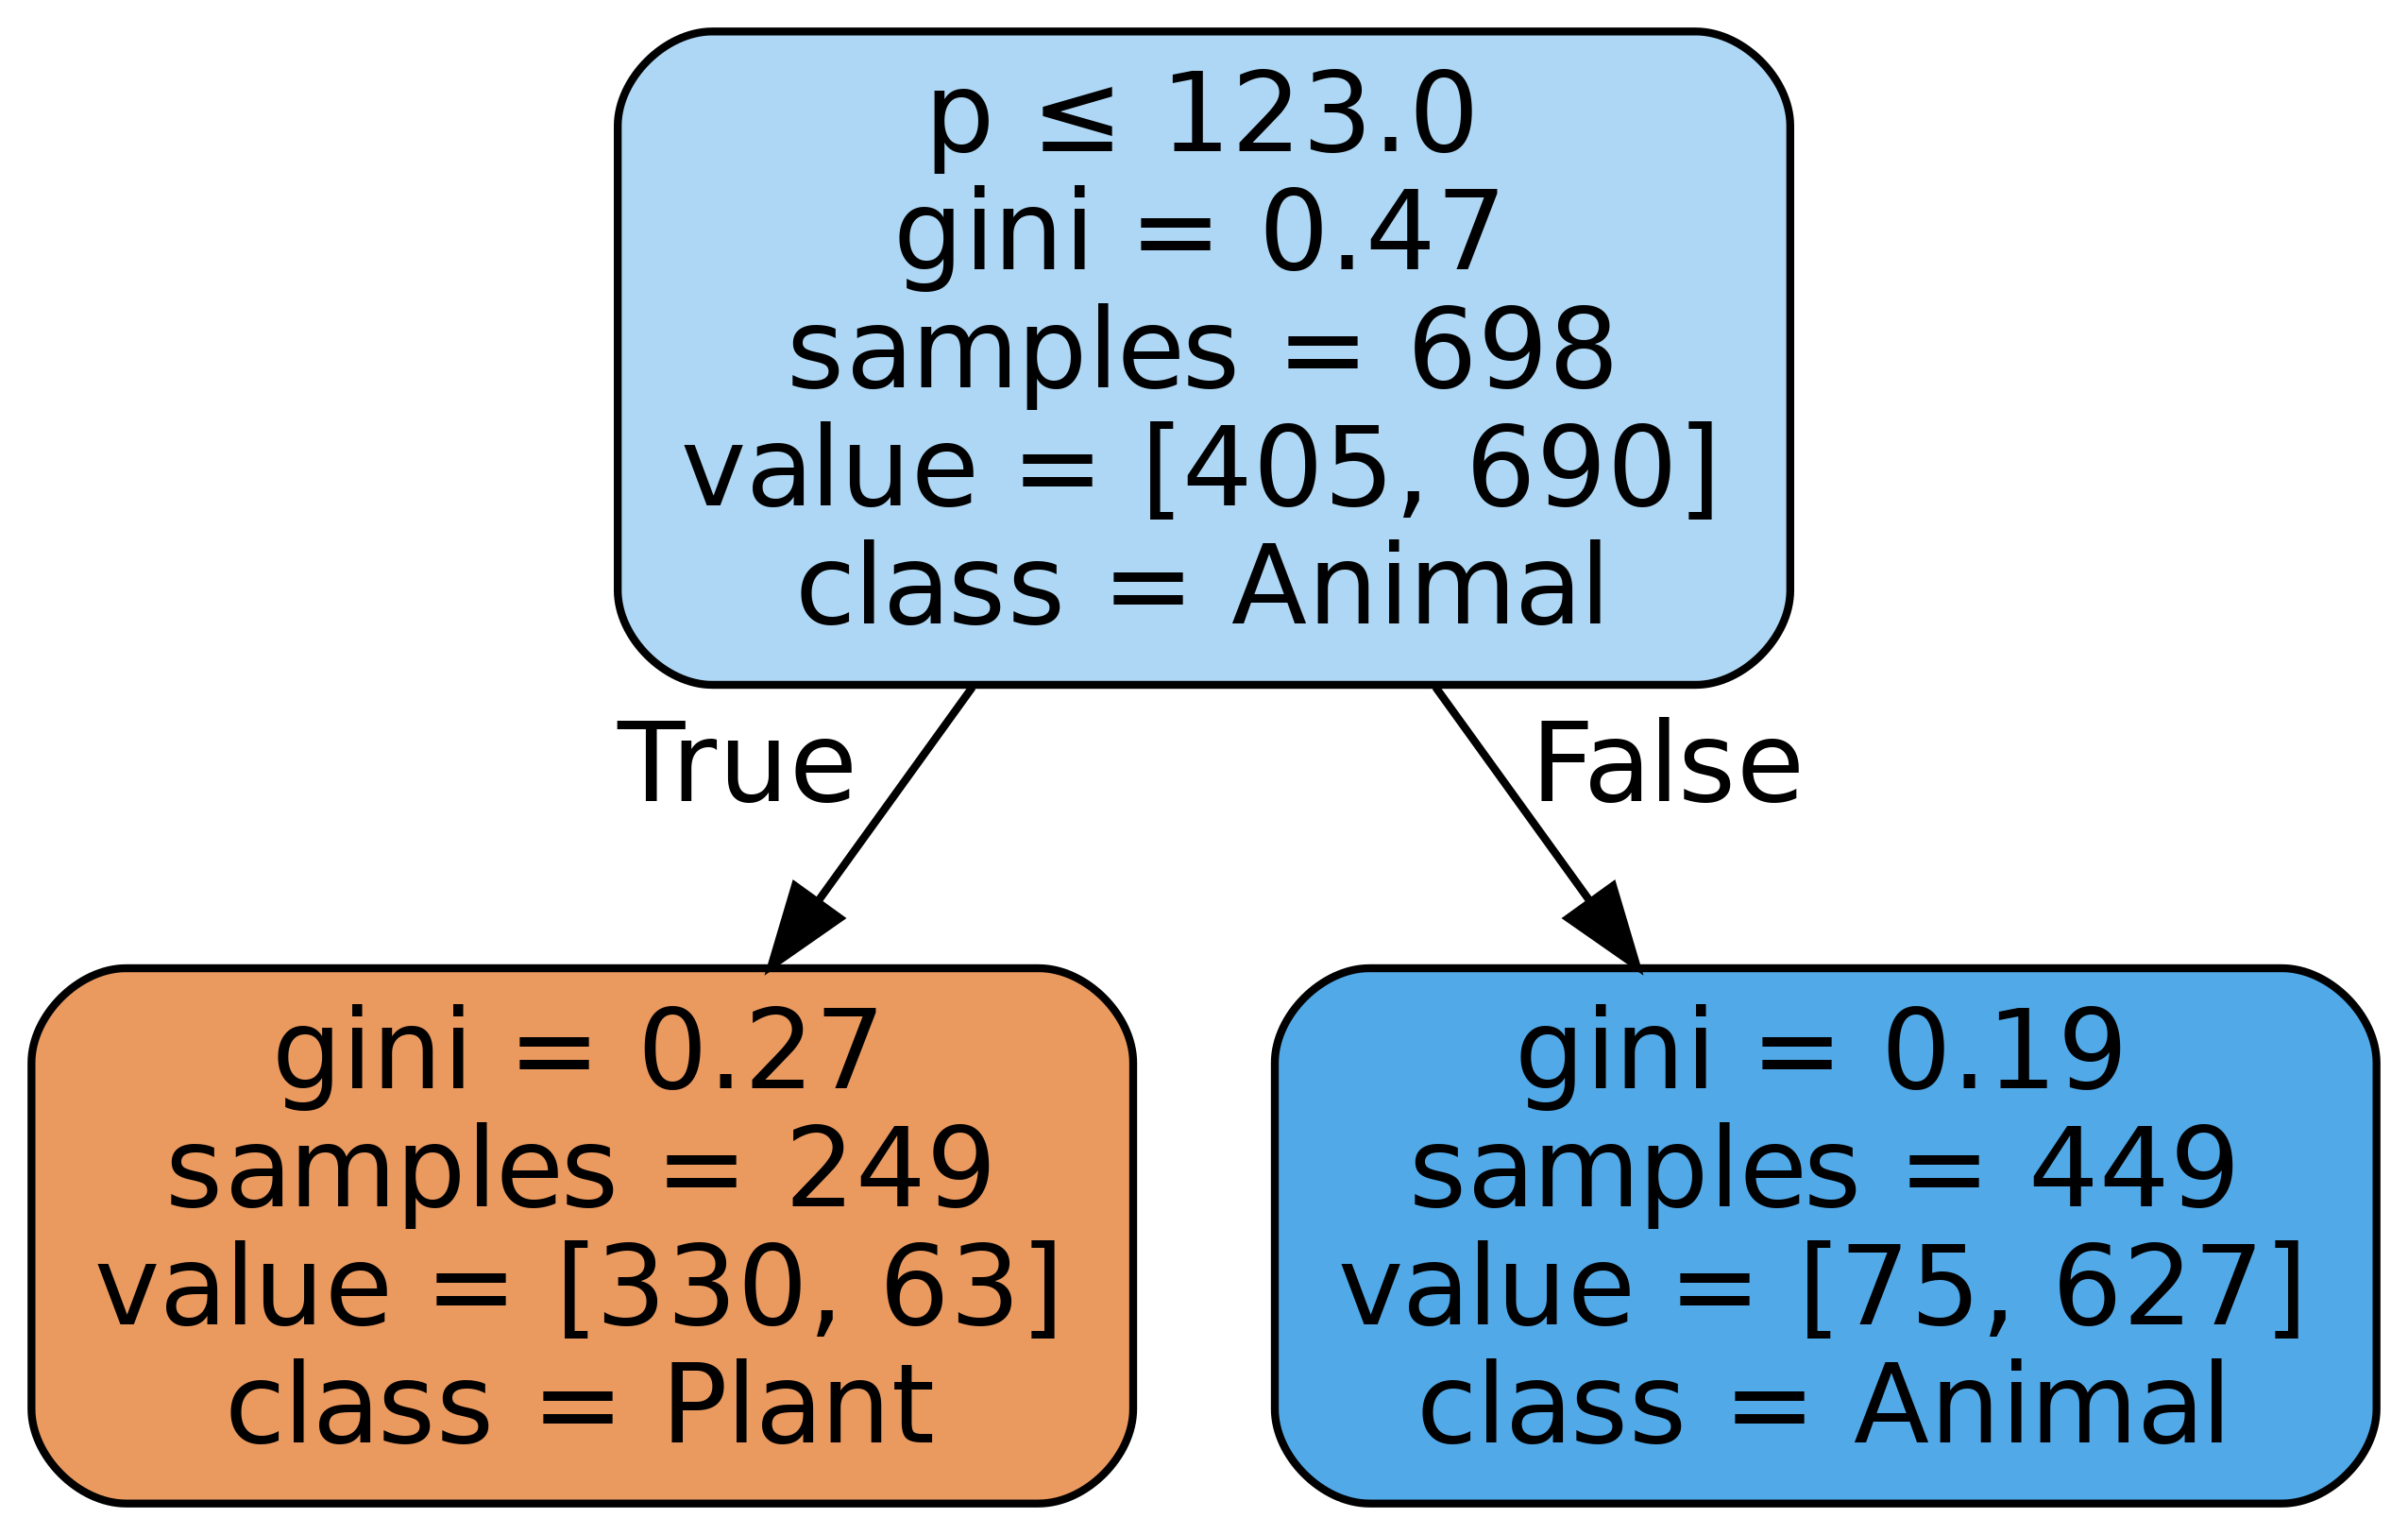

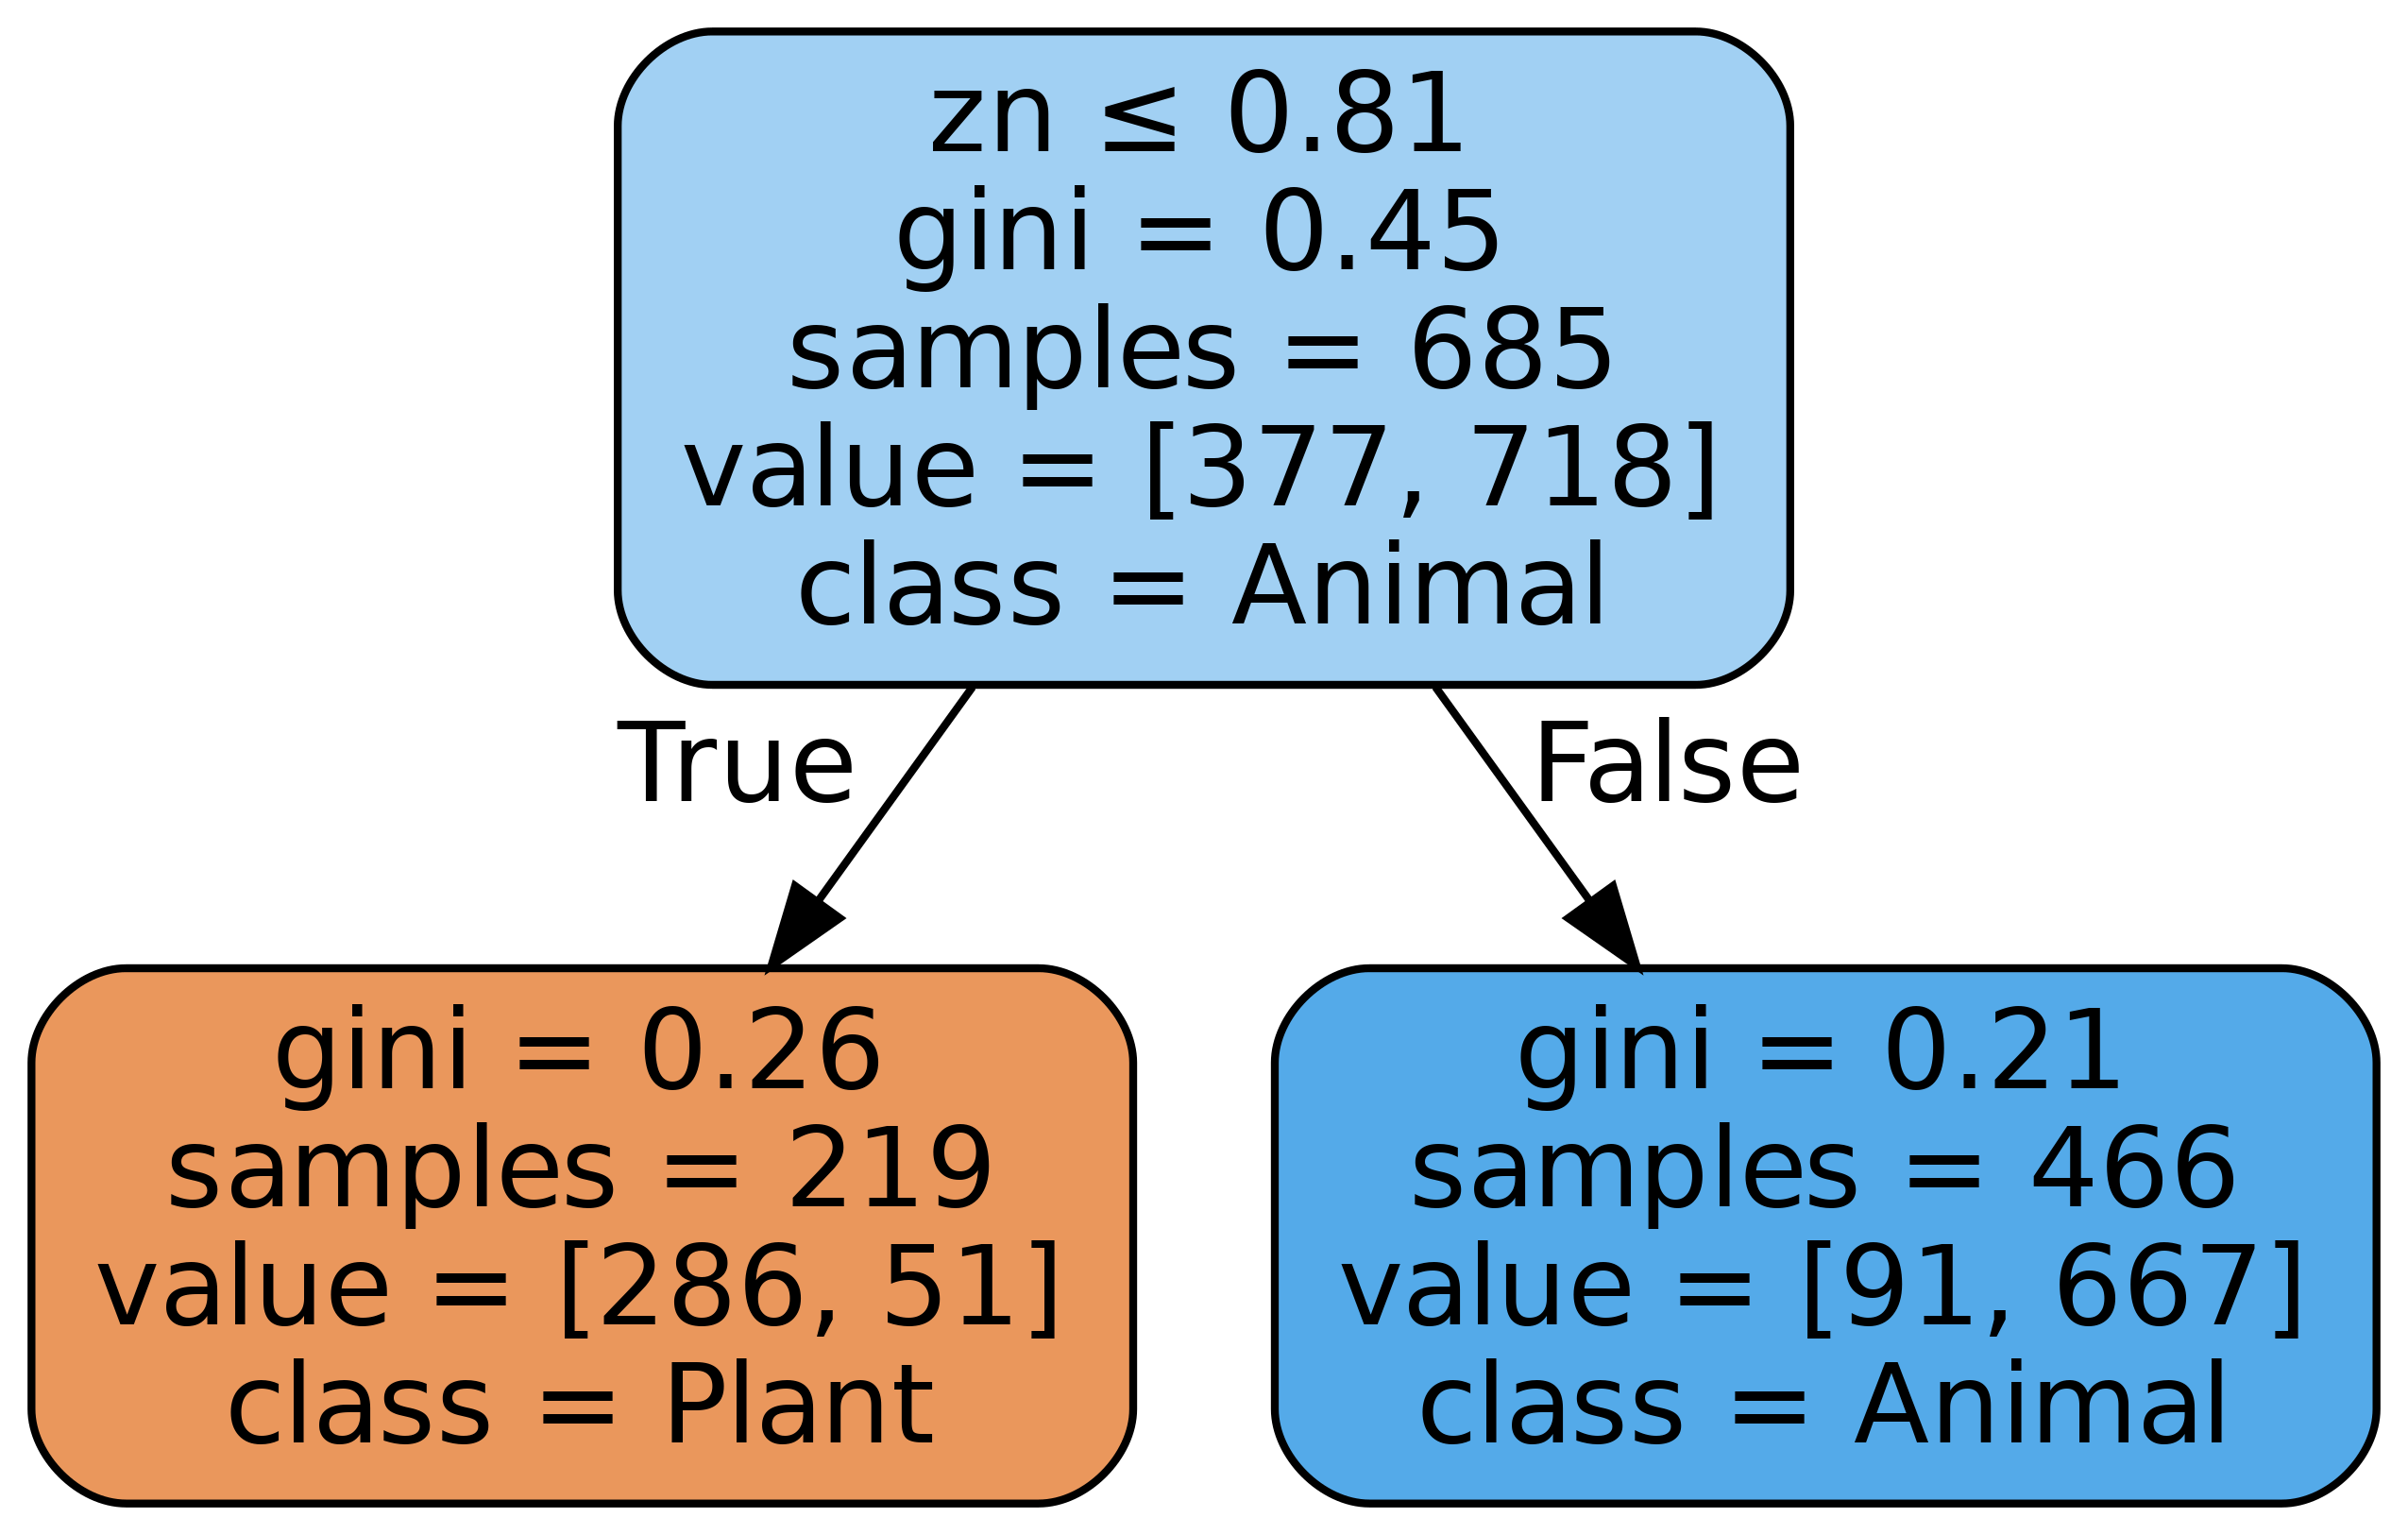

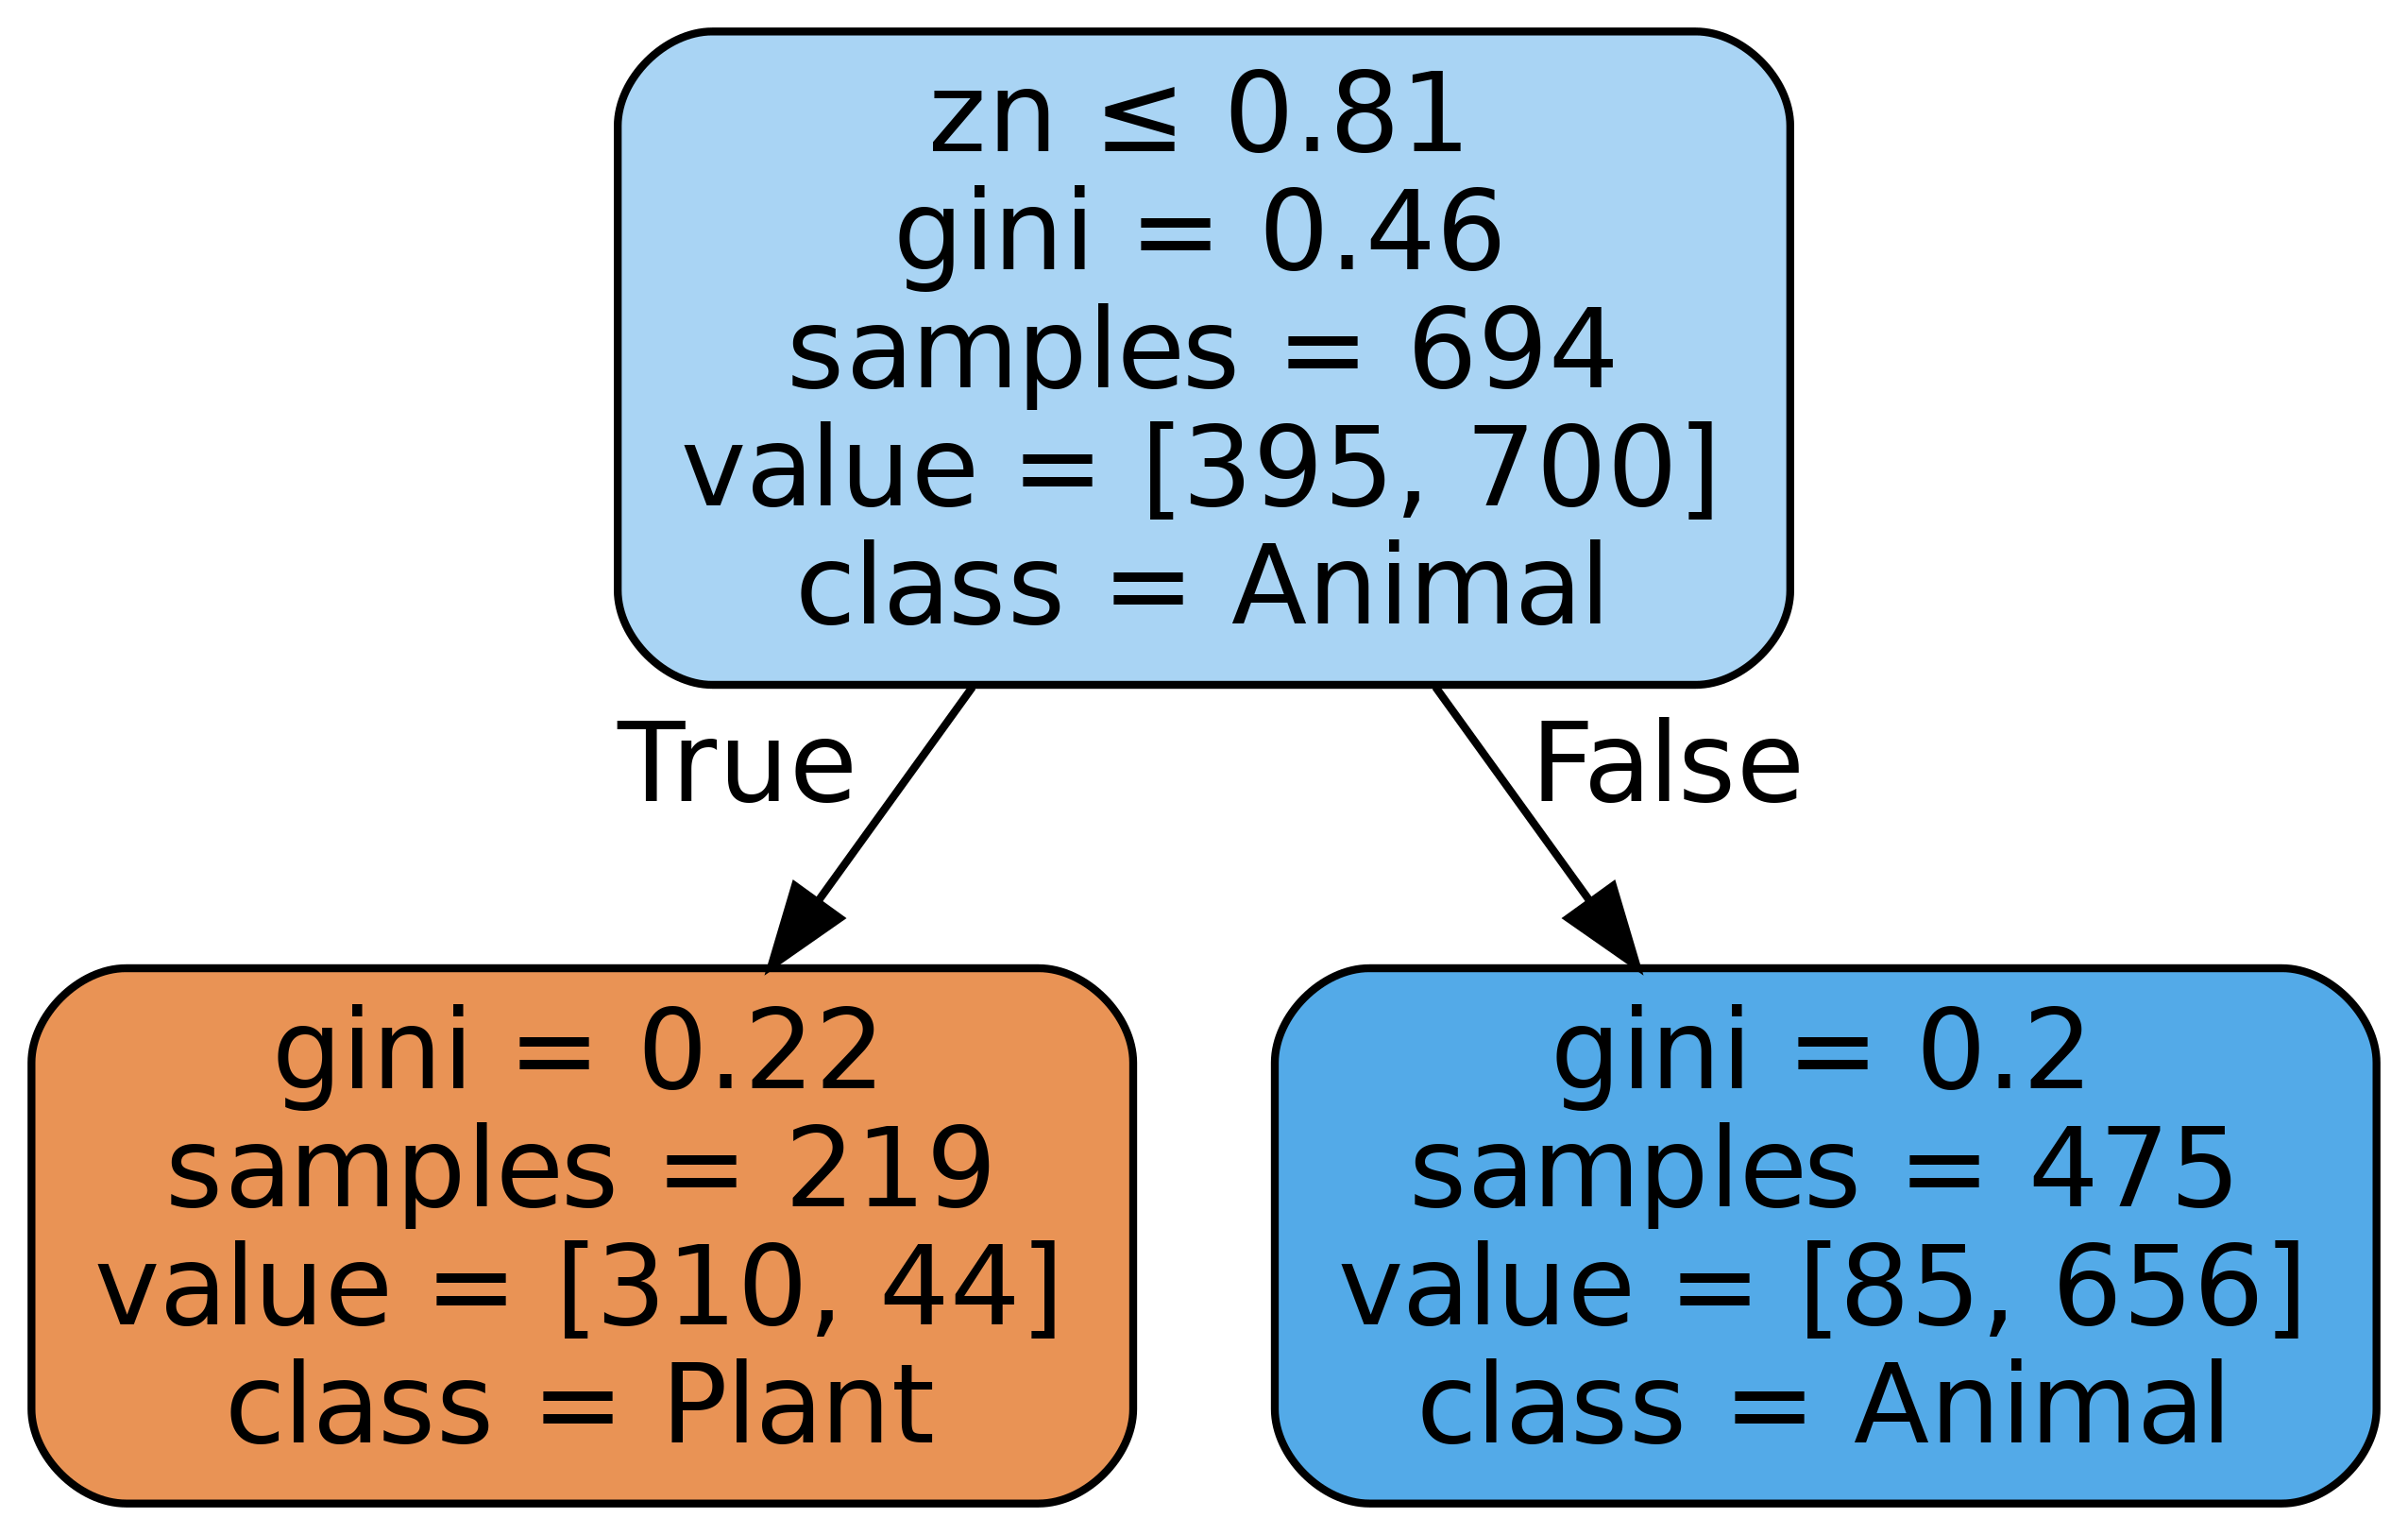

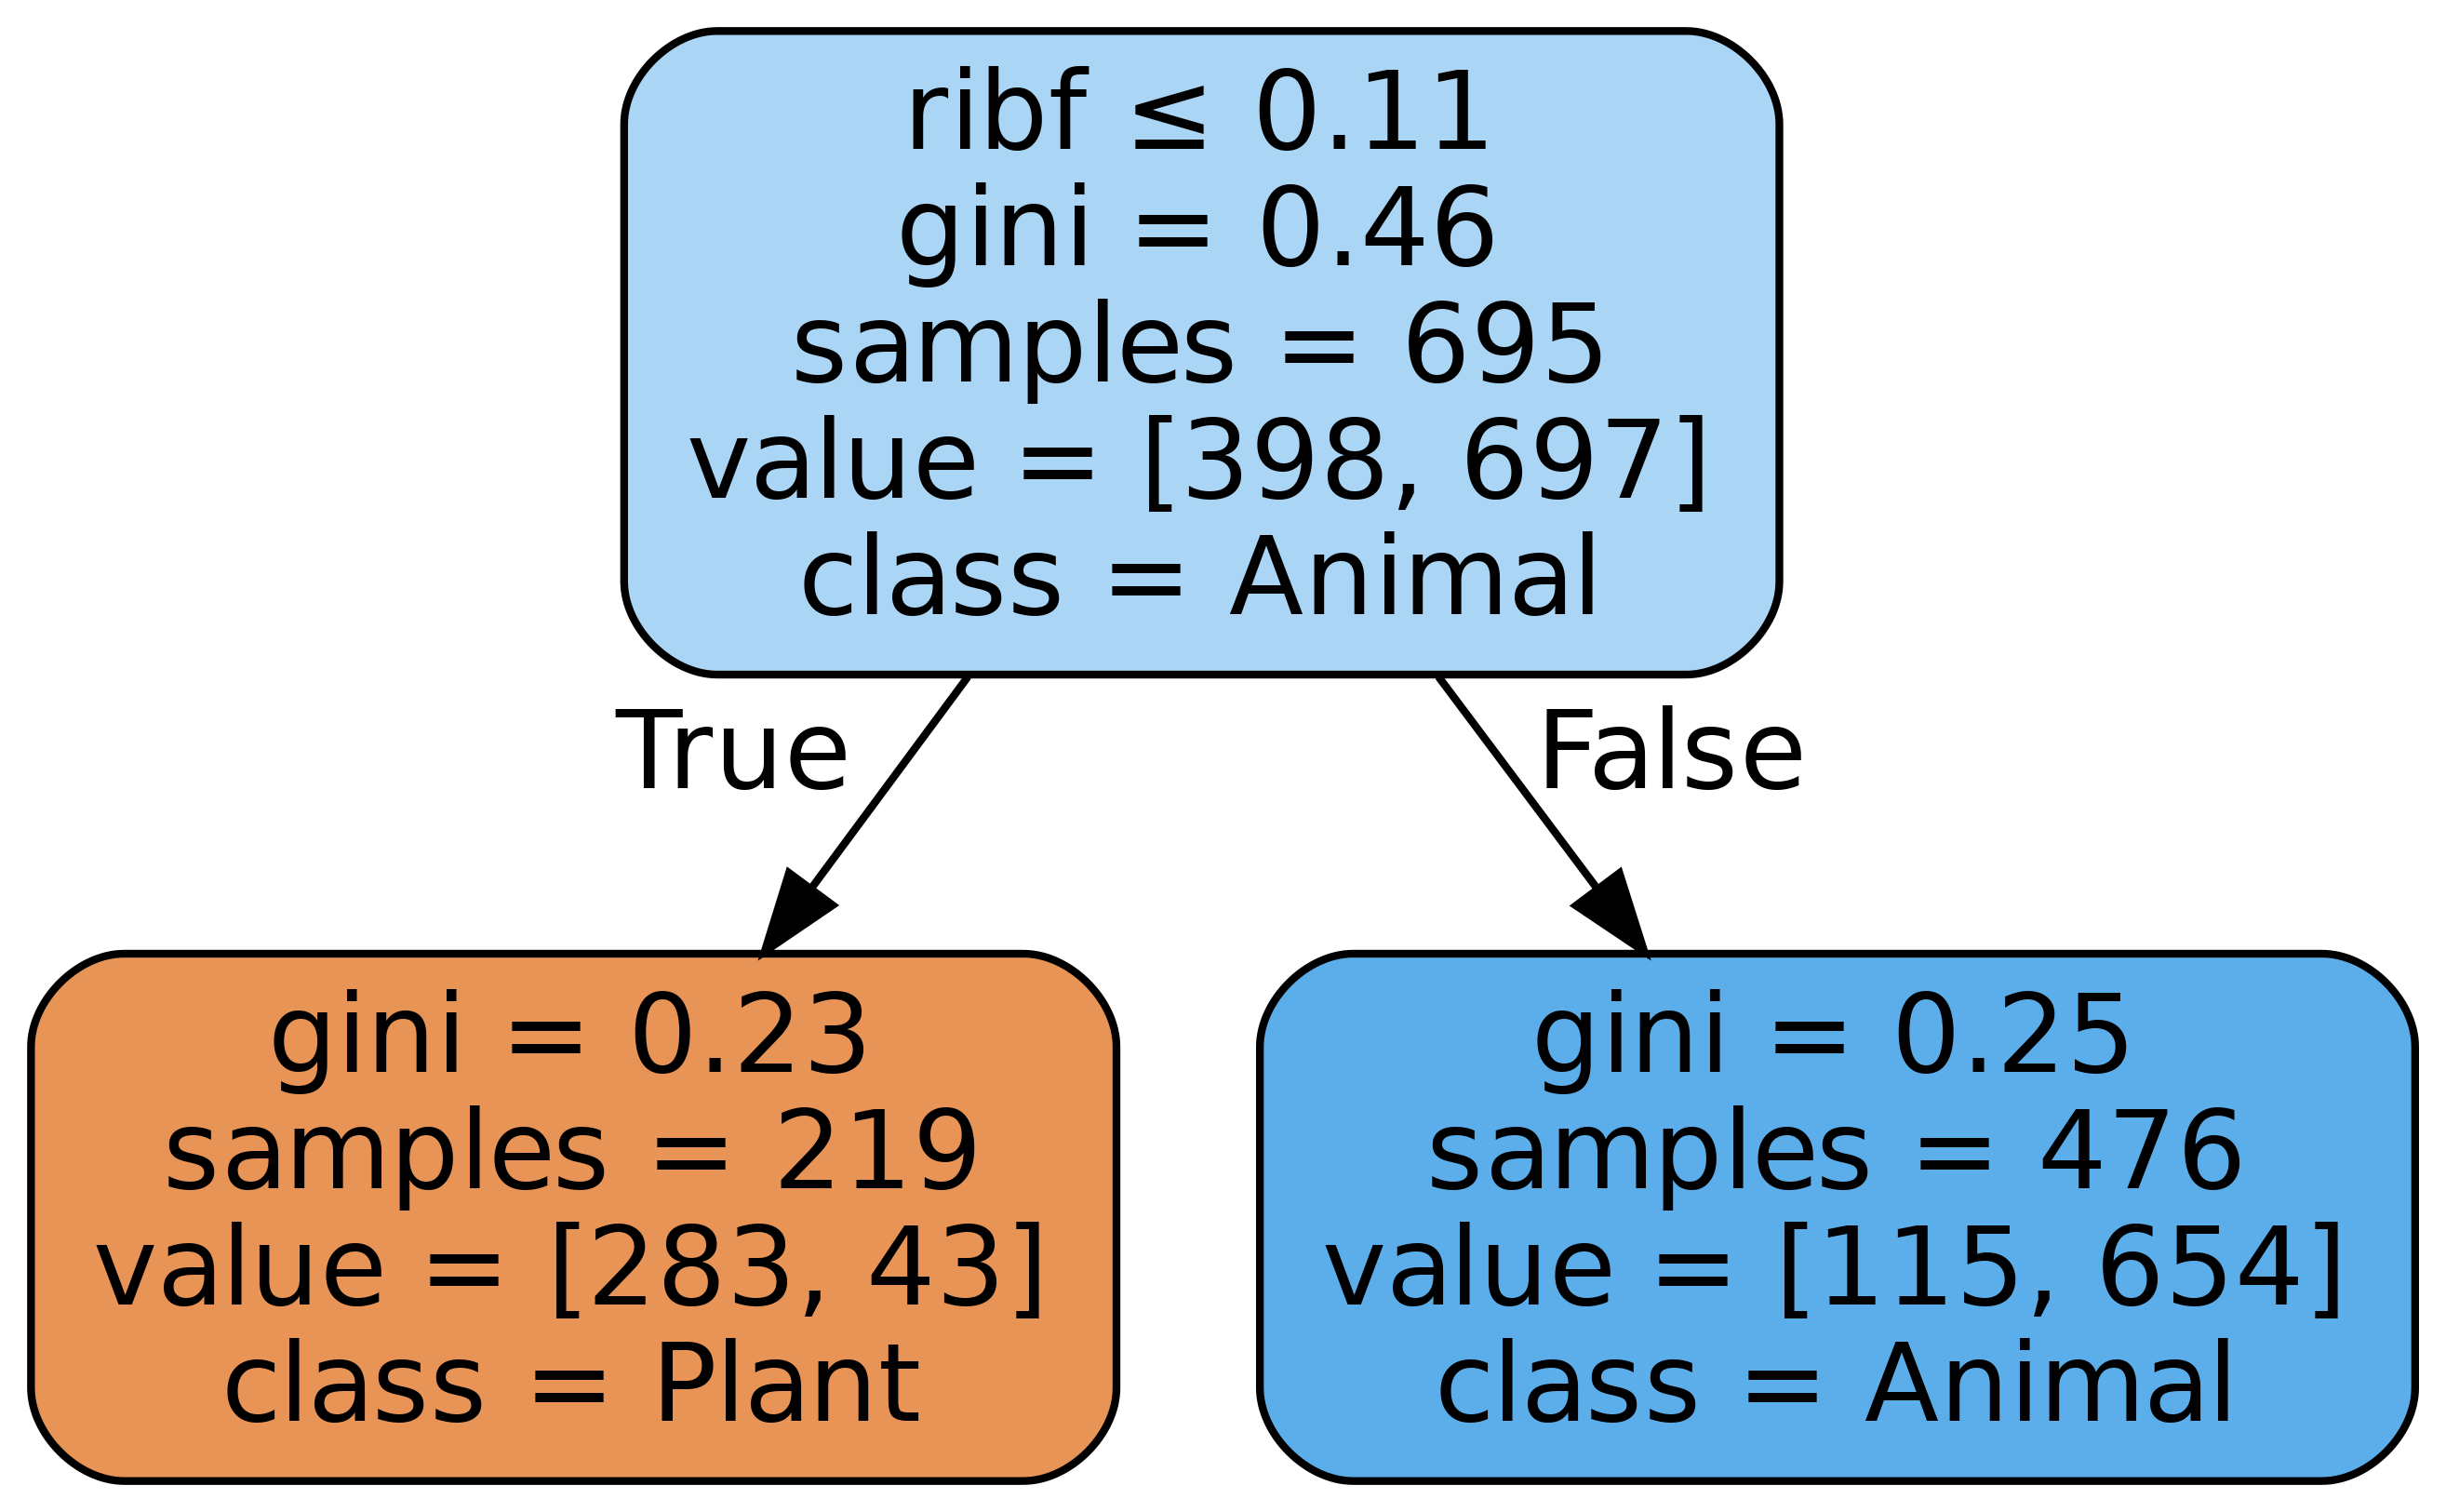

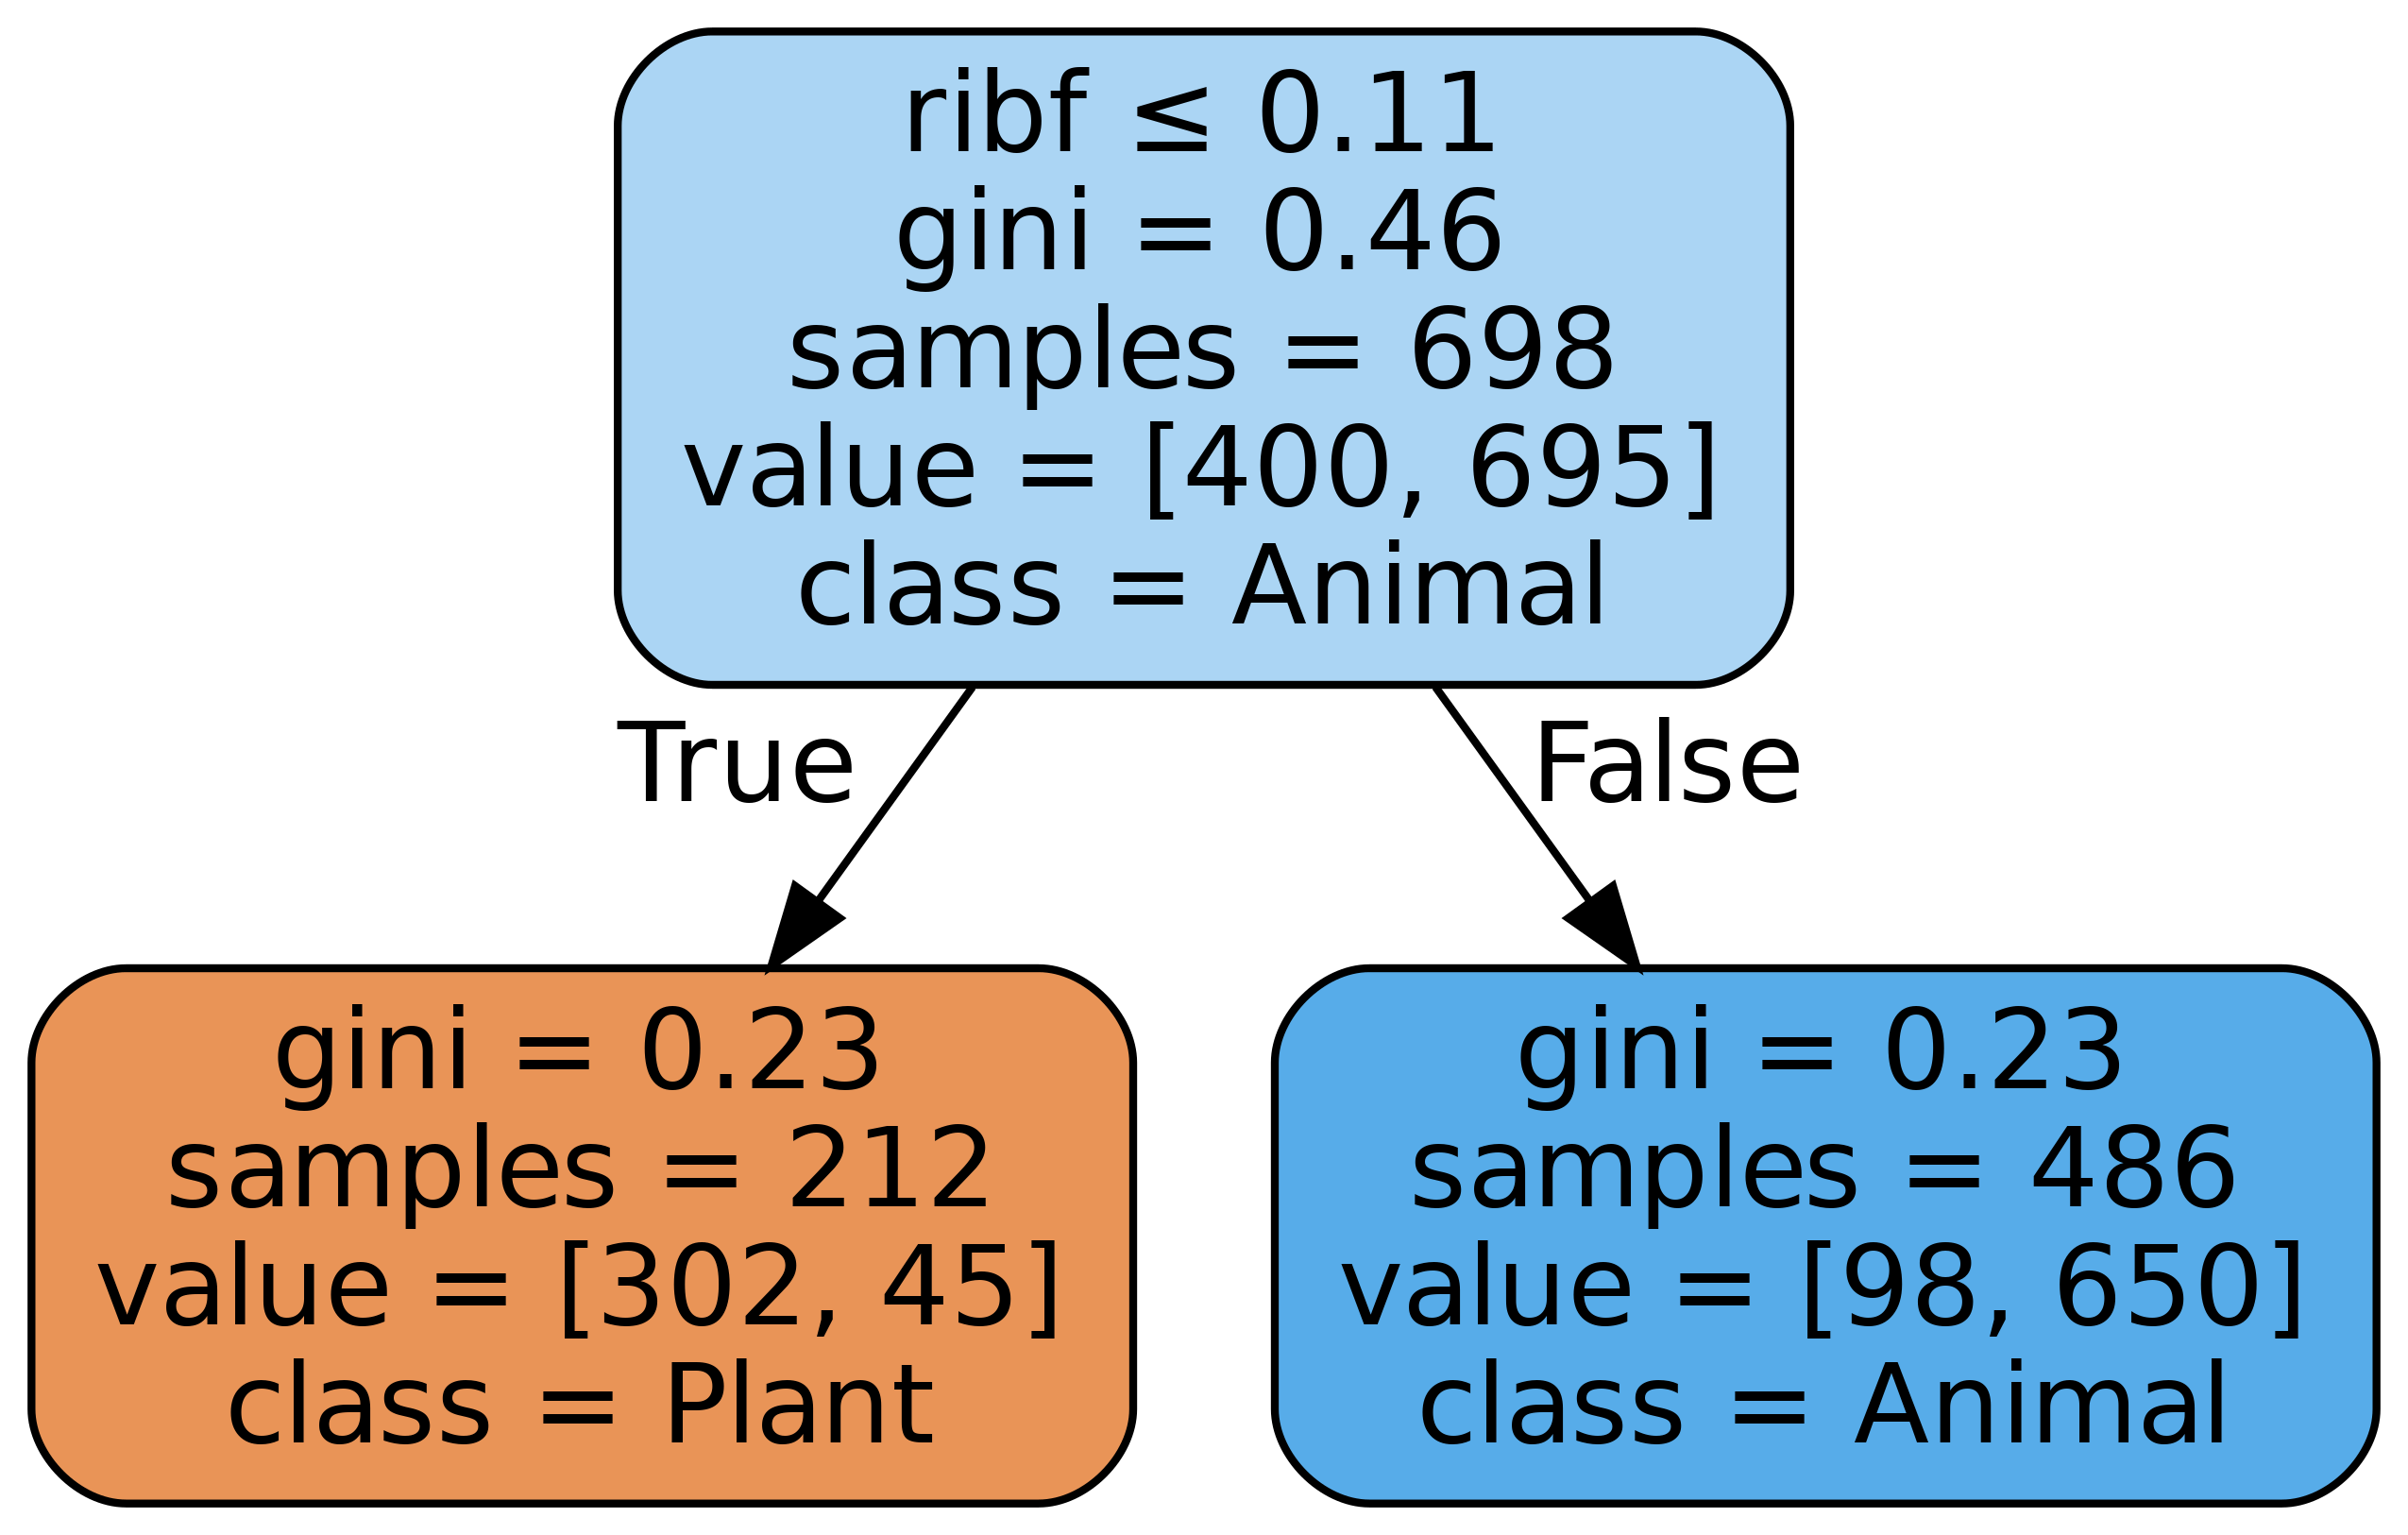

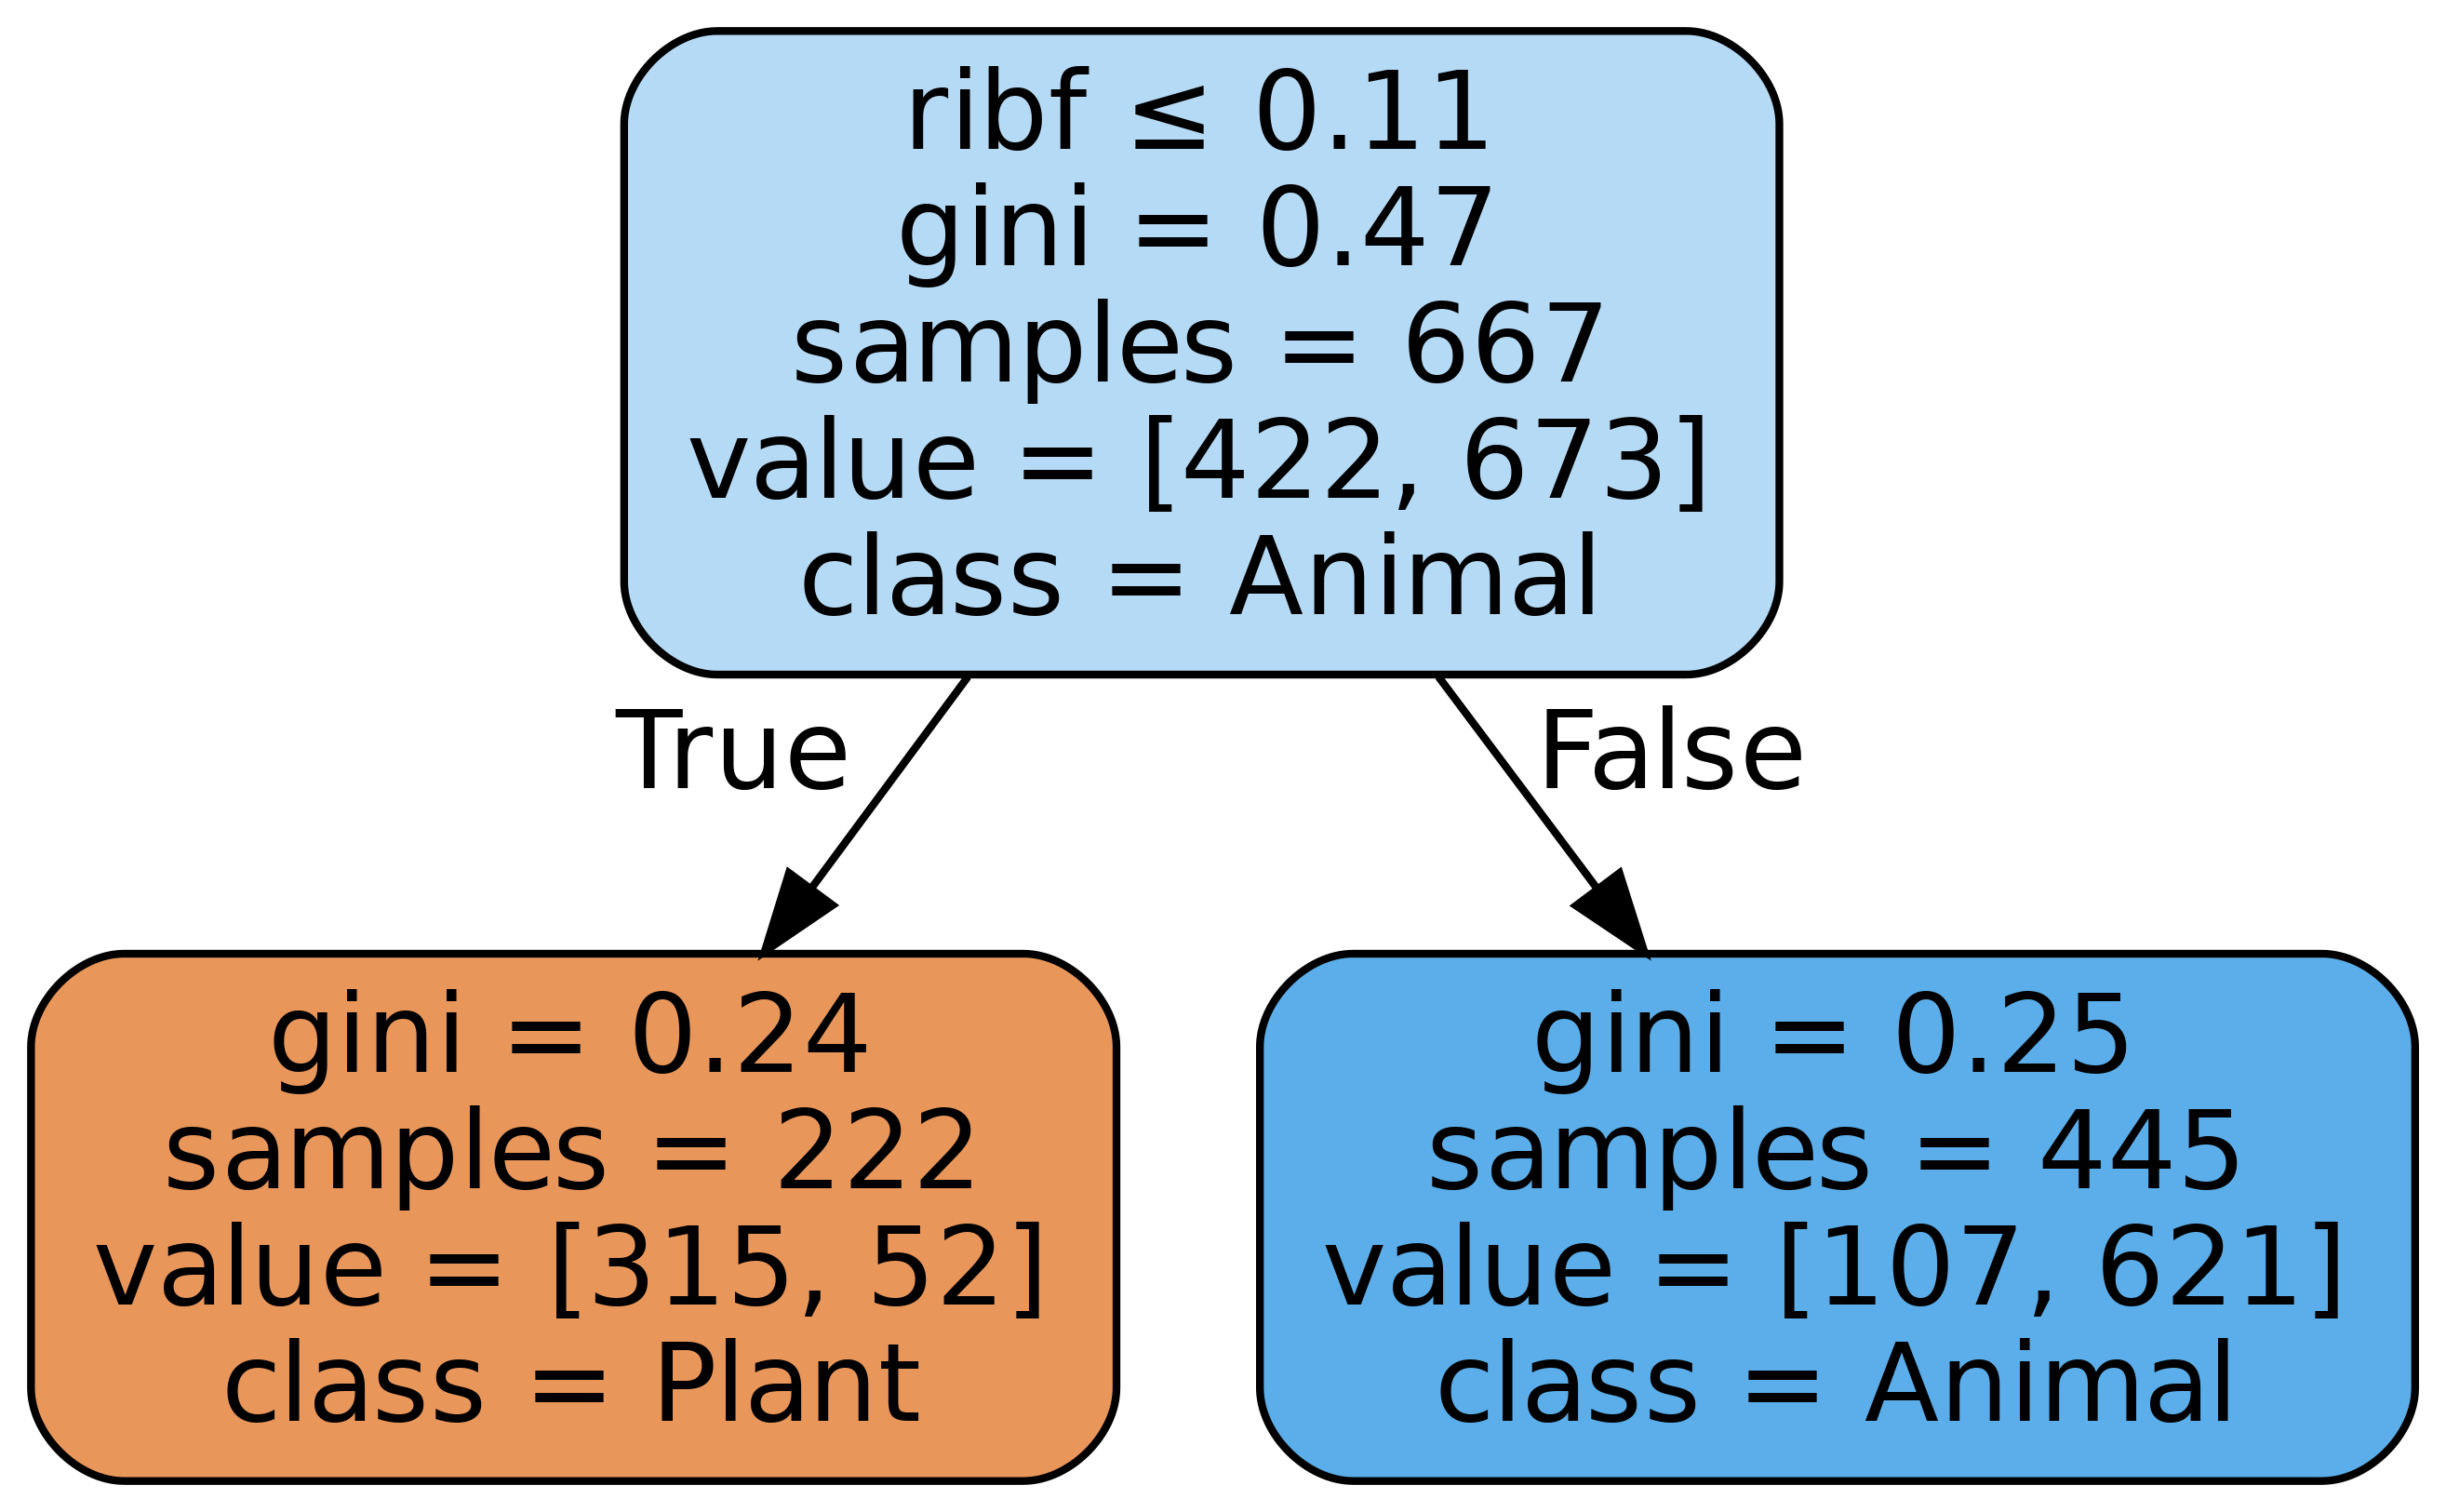

In [13]:
# Draw a graph of the best decision tree
from sklearn.tree import export_graphviz
from IPython.display import display

# Export as dot file
def graph_tree(tree):
    export_graphviz(tree, out_file='tree.dot', 
                    feature_names = X2.columns,
                    class_names = ['Plant','Animal'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, special_characters=True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in jupyter notebook
    from IPython.display import Image
    return(Image(filename = 'tree.png'))

# Loop over the top five:
images = [graph_tree(tree) for tree in ranked.iloc[:11,0]]
display(*images)